In [1]:
import os
import sys
import random
import time
from random import seed, randint
import argparse
import platform
from datetime import datetime
import imp
import numpy as np
import fileinput
from itertools import product
import pandas as pd
from scipy.interpolate import griddata
from scipy.interpolate import interp2d
import seaborn as sns
from os import listdir

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata
import matplotlib as mpl
# sys.path.insert(0,'..')
# from notebookFunctions import *
# from .. import notebookFunctions

from Bio.PDB.PDBParser import PDBParser
from pyCodeLib import *
%matplotlib inline
# plt.rcParams['figure.figsize'] = (10,6.180)    #golden ratio
# %matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams['figure.figsize'] = [16.18033, 10]    #golden ratio
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['figure.dpi'] = 100

In [3]:
res_set = {}
res_set['GLY'] = {'CA', 'N', 'O', 'C'}
res_set['ALA'] = {'CA', 'CB', 'N', 'O', 'C'}
res_set['VAL'] = {'CA', 'CB', 'CG2', 'CG1', 'N', 'O', 'C'}
res_set['CYS'] = {'CA', 'CB', 'SG', 'N', 'O', 'C'}
res_set['PRO'] = {'CA', 'CB', 'CG', 'CD', 'N', 'O', 'C'}
res_set['LEU'] = {'CD1', 'CA', 'CD2', 'CB', 'CG', 'N', 'O', 'C'}
res_set['ILE'] = {'CD1', 'CA', 'CB', 'CG2', 'CG1', 'N', 'O', 'C'}
res_set['MET'] = {'CA', 'CB', 'SD', 'CG', 'CE', 'N', 'O', 'C'}
res_set['TRP'] = {'CD1', 'CA', 'CZ3', 'NE1', 'CD2', 'CB', 'CG', 'CZ2', 'CH2', 'CE3', 'N', 'O', 'CE2', 'C'}
res_set['PHE'] = {'CD1', 'CA', 'CD2', 'CB', 'CE1', 'CG', 'CZ', 'N', 'O', 'CE2', 'C'}


res_set['SER'] = {'CA', 'OG', 'CB', 'N', 'O', 'C'}
res_set['THR'] = {'CA', 'CB', 'CG2', 'N', 'OG1', 'O', 'C'}
res_set['TYR'] = {'CD1', 'CA', 'CD2', 'CB', 'CE1', 'OH', 'CG', 'CZ', 'N', 'O', 'CE2', 'C'}
res_set["GLN"] = {'CA', 'CB', 'CG', 'CD', 'OE1', 'NE2', 'N', 'O', 'C'}
res_set['ASN'] = {'CA', 'OD1', 'CB', 'CG', 'ND2', 'N', 'O', 'C'}


res_set['LYS'] = {'CA', 'CB', 'CE', 'CG', 'CD', 'NZ', 'N', 'O', 'C'}
res_set['ARG'] = {'CA', 'NE', 'CB', 'CG', 'CD', 'NH2', 'CZ', 'NH1', 'N', 'O', 'C'}
res_set['HIS'] = {'CA', 'ND1', 'CD2', 'CB', 'CE1', 'CG', 'NE2', 'N', 'O', 'C'}


res_set['ASP'] = {'OD2', 'CA', 'OD1', 'CB', 'CG', 'N', 'O', 'C'}
res_set['GLU'] = {'CA', 'OE2', 'CB', 'CG', 'CD', 'OE1', 'N', 'O', 'C'}

In [54]:

def dis(a, b):
    return ((a[0]-b[0])**2 + (a[1]-b[1])**2 + (a[2]-b[2])**2)**0.5

def get_neighbor_list_only_side_chain(structure):

    res_list = get_res_list(structure)
#     atom_list = [a for a in get_atom_list(
#         structure) if not is_hetero(a.get_parent())]
    for res in res_list:
        for atom in get_side_chain_atoms(res.get_atoms()):
            if is_hetero(atom.get_parent()):
                print("hetero, skipped")
                continue
            atom_list.append(atom)
    # print(atom_list)
    neighbor_list = NeighborSearch(atom_list)
    return neighbor_list

def get_side_chain_atoms(atoms):
    atom_list = []
    for atom in atoms:
        if atom.get_name() in ["N", "CA", "C", "O", "OXT"]:
            continue
        if atom.element == "H":
            continue
        atom_list.append(atom)
    return atom_list

def get_side_chain_center_of_mass(atoms):
    # ensure complete first
    total = np.array([0., 0., 0.])
    total_mass = 0
    for atom in atoms:
        if atom.get_name() in ["N", "CA", "C", "O", "OXT"]:
            continue
        if atom.element == "H":
            continue
        total += atom.mass * atom.get_coord()
        total_mass += atom.mass
        # print(atom.get_name(), atom.get_coord())
    x_com = total / total_mass
    return x_com

def get_all_non_H_atoms(res):
    atoms = res.get_atoms()
    name_list = []
    for atom in atoms:
        name = atom.get_name()
        if atom.element == "H":
            continue
        name_list.append(name)
    return set(name_list)


def get_x_more_check(res, res_set=res_set):
    resName = res.get_resname()
    if resName == "GLY":
        x_com = res["CA"].get_coord()
    else:
        set_of_all_non_H_atoms = get_all_non_H_atoms(res)
        if set_of_all_non_H_atoms != res_set[resName]:
            print("atom not complete", set_of_all_non_H_atoms, "should be ", res_set[resName])
        x_com = get_side_chain_center_of_mass(res.get_atoms())
    
    n = res["N"].get_coord()
    ca = res["CA"].get_coord()
    c = res["C"].get_coord()

    A = np.zeros((3,3))
    A[:,0] = n
    A[:,1] = ca
    A[:,2] = c

    A_inv = np.linalg.inv(A)
    x = A_inv.dot(x_com)
    return x


def get_x(res):
    x_com = get_side_chain_center_of_mass(res.get_atoms())
    
    n = res["N"].get_coord()
    ca = res["CA"].get_coord()
    c = res["C"].get_coord()

    A = np.zeros((3,3))
    A[:,0] = n
    A[:,1] = ca
    A[:,2] = c

    A_inv = np.linalg.inv(A)
    x = A_inv.dot(x_com)
    return x

def get_x_with_regularization(res, alpha=0.001):
    x_com = get_side_chain_center_of_mass(res.get_atoms())
    
    n = res["N"].get_coord()
    ca = res["CA"].get_coord()
    c = res["C"].get_coord()

    A = np.zeros((3,3))
    A[:,0] = n
    A[:,1] = ca
    A[:,2] = c

    # A_inv = np.linalg.inv(A)
    # x = A_inv.dot(x_com)
    # return x
    A_inv_regularized = np.linalg.inv(A.T.dot(A) + alpha*np.eye(3)).dot(A.T)
    x_regularized = A_inv_regularized.dot(x_com)
    r = dis(A.dot(x_regularized), x_com)
    return x_regularized, r


def get_x_vector_based(res, alpha=0.001):
    n = res["N"].get_coord()
    ca = res["CA"].get_coord()
    c = res["C"].get_coord()

    x_com = get_side_chain_center_of_mass(res.get_atoms())
    ca_x_com = x_com - ca

    n_ca = ca - n
    ca_c = c - ca
    x3 = np.cross(n_ca, ca_c)

    n_ca_unit = n_ca / np.linalg.norm(n_ca)
    ca_c_unit = ca_c / np.linalg.norm(ca_c)
    x3_unit = x3 / np. linalg.norm(x3)

    A = np.zeros((3,3))
    A[:,0] = n_ca_unit
    A[:,1] = ca_c_unit
    A[:,2] = x3_unit

    A_inv = np.linalg.inv(A)
    x = A_inv.dot(ca_x_com)
    return x, 0

def get_x_distance_based(res, alpha=0.001):
    n = res["N"].get_coord()
    ca = res["CA"].get_coord()
    c = res["C"].get_coord()

    x_com = get_side_chain_center_of_mass(res.get_atoms())

    x = np.array([dis(x_com, n), dis(x_com, ca), dis(x_com, c)])
    return x, dis(ca, x_com)

In [5]:
import glob
a_list = glob.glob("/Users/weilu/Research/server/feb_2020/energy_evaluations_and_database_survey/my_CATH_database/*.pdb")

In [55]:
%%time

# # res1.index should be at least 1 amino acid away
# They should be in direct contact. say 6.5.
parser = PDBParser()
info = []
skipped_residues_count = 0
# for i, a in enumerate(a_list[:300]):
# for i, a in enumerate(a_list[:10]):
for i, a in enumerate(a_list):
    pdb = a.split("/")[-1].split(".")[0]
    structure = parser.get_structure("x", a)
    neighbor_list = get_neighbor_list_only_side_chain(structure)
    for res1 in structure.get_residues():
        resName1 = res1.get_resname()
        if resName1 == "GLY":
            continue
        set_of_all_non_H_atoms = get_all_non_H_atoms(res1)
        if set_of_all_non_H_atoms != res_set[resName1]:
            skipped_residues_count += 1
            # print("skip", resName, res.get_id(), "atom not complete", set_of_all_non_H_atoms, "should be ", res_set[resName])
            continue
        x_com_1 = get_side_chain_center_of_mass(res1.get_atoms())
        ca_1 = res1["CA"].get_coord()
        cb_1 = res1["CB"].get_coord()
        
        for res2 in get_neighbors_within_radius(neighbor_list, res1, 10.0):
            resName2 = res2.get_resname()
            if resName2 == "GLY":
                continue
            set_of_all_non_H_atoms = get_all_non_H_atoms(res2)
            if set_of_all_non_H_atoms != res_set[resName2]:
                skipped_residues_count += 1
                # print("skip", resName, res.get_id(), "atom not complete", set_of_all_non_H_atoms, "should be ", res_set[resName])
                continue
            if res1 == res2:
                continue
            in_real_contact = False
#             for atom in res1.get_atoms():
#                 if res2 in neighbor_list.search(atom.get_coord(), 4, level='R'):
#                     in_real_contact = True
            atom_list = get_side_chain_atoms(res1.get_atoms())
            for atom in atom_list:
                if res2 in neighbor_list.search(atom.get_coord(), 4, level='R'):
                    in_real_contact = True
            if not in_real_contact:
                # print(pdb, res1.id[1], resName1, res2.id[1], resName2)
                continue
            x_com_2 = get_side_chain_center_of_mass(res2.get_atoms())
            ca_2 = res2["CA"].get_coord()
            cb_2 = res2["CB"].get_coord()
            info.append([pdb, res1.id[1], resName1, res2.id[1], resName2, dis(ca_1, ca_2), dis(x_com_1, x_com_2), dis(cb_1, cb_2), dis(ca_1, x_com_2), dis(x_com_1, ca_2)])
print("skipped_residues_count", skipped_residues_count)

skipped_residues_count 14116
CPU times: user 2min 38s, sys: 2.3 s, total: 2min 40s
Wall time: 4min 19s


In [56]:
data = pd.DataFrame(info, columns=["Protein", "id1", "ResName1", "id2", "ResName2", "r_ca_ca", "r_com_com", "r_cb_cb", "r_ca_com", "r_com_ca"])
data.shape

(160415, 10)

In [51]:
%%time

# # res1.index should be at least 1 amino acid away
# They should be in direct contact. say 6.5.
parser = PDBParser()
info = []
skipped_residues_count = 0
# for i, a in enumerate(a_list[:300]):
# for i, a in enumerate(a_list[:10]):
for i, a in enumerate(a_list):
    pdb = a.split("/")[-1].split(".")[0]
    structure = parser.get_structure("x", a)
    neighbor_list = get_neighbor_list(structure)
    for res1 in structure.get_residues():
        resName1 = res1.get_resname()
        if resName1 == "GLY":
            continue
        set_of_all_non_H_atoms = get_all_non_H_atoms(res1)
        if set_of_all_non_H_atoms != res_set[resName1]:
            skipped_residues_count += 1
            # print("skip", resName, res.get_id(), "atom not complete", set_of_all_non_H_atoms, "should be ", res_set[resName])
            continue
        x_com_1 = get_side_chain_center_of_mass(res1.get_atoms())
        ca_1 = res1["CA"].get_coord()
        cb_1 = res1["CB"].get_coord()
        
        for res2 in get_neighbors_within_radius(neighbor_list, res1, 10.0):
            resName2 = res2.get_resname()
            if resName2 == "GLY":
                continue
            set_of_all_non_H_atoms = get_all_non_H_atoms(res2)
            if set_of_all_non_H_atoms != res_set[resName2]:
                skipped_residues_count += 1
                # print("skip", resName, res.get_id(), "atom not complete", set_of_all_non_H_atoms, "should be ", res_set[resName])
                continue
            if res1 == res2:
                continue
            in_real_contact = False
#             for atom in res1.get_atoms():
#                 if res2 in neighbor_list.search(atom.get_coord(), 4, level='R'):
#                     in_real_contact = True
            atom_list = get_side_chain_atoms(res1.get_atoms())
            for atom in atom_list:
                if res2 in neighbor_list.search(atom.get_coord(), 4, level='R'):
                    in_real_contact = True
            if not in_real_contact:
                # print(pdb, res1.id[1], resName1, res2.id[1], resName2)
                continue
            x_com_2 = get_side_chain_center_of_mass(res2.get_atoms())
            ca_2 = res2["CA"].get_coord()
            cb_2 = res2["CB"].get_coord()
            info.append([pdb, res1.id[1], resName1, res2.id[1], resName2, dis(ca_1, ca_2), dis(x_com_1, x_com_2), dis(cb_1, cb_2), dis(ca_1, x_com_2), dis(x_com_1, ca_2)])
print("skipped_residues_count", skipped_residues_count)

skipped_residues_count 19067
CPU times: user 4min 13s, sys: 3.31 s, total: 4min 17s
Wall time: 6min 14s


In [52]:
data = pd.DataFrame(info, columns=["Protein", "id1", "ResName1", "id2", "ResName2", "r_ca_ca", "r_com_com", "r_cb_cb", "r_ca_com", "r_com_ca"])
data.shape

(400257, 10)

In [50]:
data = pd.DataFrame(info, columns=["Protein", "id1", "ResName1", "id2", "ResName2", "r_ca_ca", "r_com_com", "r_cb_cb", "r_ca_com", "r_com_ca"])
data.shape

(633797, 10)

In [57]:
data.to_csv("/Users/weilu/Research/data/survey_center_of_mass_distance_complete_side_chain_in_real_contact.csv")

In [47]:
data_1.to_csv("/Users/weilu/Research/data/survey_center_of_mass_distance_test_4_in_real_contact.csv")

In [48]:
data_2.to_csv("/Users/weilu/Research/data/survey_center_of_mass_distance_test_35_in_real_contact.csv")

In [31]:
data_1["id"] = data_1["Protein"] + data_1["id1"].astype(str) + data_1["id2"].astype(str)

In [32]:
data_2["id"] = data_2["Protein"] + data_2["id1"].astype(str) + data_2["id2"].astype(str)

In [42]:
id_list = data_2["id"].to_list()
data_1.query("id not in @id_list")

,Protein,id1,ResName1,id2,ResName2,r_ca_ca,r_com_com,r_cb_cb,r_ca_com,r_com_ca,id
0,3c18A03,233,ARG,241,GLU,11.584703,5.853921,9.063191,10.052837,7.410306,3c18A03233241
3,3c18A03,233,ARG,237,TRP,8.558047,3.946257,7.460506,6.392295,5.876545,3c18A03233237
5,3c18A03,234,ASP,286,GLU,8.758088,7.766050,9.401233,6.702904,10.310185,3c18A03234286
8,3c18A03,235,ARG,286,GLU,6.891255,8.860679,7.342536,4.817196,10.257261,3c18A03235286
11,3c18A03,235,ARG,237,TRP,6.672196,7.595253,7.877475,7.536017,7.333605,3c18A03235237
12,3c18A03,236,PRO,286,GLU,4.630179,4.055624,4.213188,4.324645,5.315247,3c18A03236286
15,3c18A03,236,PRO,284,THR,5.513925,4.544342,3.571667,4.991396,5.602587,3c18A03236284
17,3c18A03,237,TRP,241,GLU,6.046696,5.982852,4.727397,4.671861,6.158440,3c18A03237241
18,3c18A03,237,TRP,233,ARG,8.558047,3.946257,7.460506,5.876545,6.392295,3c18A03237233
22,3c18A03,237,TRP,242,LEU,6.449441,4.784423,4.981650,5.466359,5.312397,3c18A03237242


In [41]:
c

1176

In [39]:
"3c18A03233234" in data_2["id"].to_list()

True

In [33]:
data_2.shape

(5626, 11)

In [22]:
data_1.shape

(6802, 10)

In [25]:
data_2 = data

In [17]:
data_1 = data

In [23]:
data = pd.DataFrame(info, columns=["Protein", "id1", "ResName1", "id2", "ResName2", "r_ca_ca", "r_com_com", "r_cb_cb", "r_ca_com", "r_com_ca"])
data.shape

(5626, 10)

In [14]:
data = pd.DataFrame(info, columns=["Protein", "id1", "ResName1", "id2", "ResName2", "r_ca_ca", "r_com_com", "r_cb_cb", "r_ca_com", "r_com_ca"])
data.shape

(5626, 10)

In [12]:
data = pd.DataFrame(info, columns=["Protein", "id1", "ResName1", "id2", "ResName2", "r_ca_ca", "r_com_com", "r_cb_cb", "r_ca_com", "r_com_ca"])
data.shape

(17883, 10)

In [11]:
%%time

# # res1.index should be at least 1 amino acid away
# They should be in direct contact. say 6.5.
parser = PDBParser()
info = []
skipped_residues_count = 0
# for i, a in enumerate(a_list[:300]):
for i, a in enumerate(a_list):
    pdb = a.split("/")[-1].split(".")[0]
    structure = parser.get_structure("x", a)
    neighbor_list = get_neighbor_list(structure)
    for res1 in structure.get_residues():
        resName1 = res1.get_resname()
        if resName1 == "GLY":
            continue
        set_of_all_non_H_atoms = get_all_non_H_atoms(res1)
        if set_of_all_non_H_atoms != res_set[resName1]:
            skipped_residues_count += 1
            # print("skip", resName, res.get_id(), "atom not complete", set_of_all_non_H_atoms, "should be ", res_set[resName])
            continue
        x_com_1 = get_side_chain_center_of_mass(res1.get_atoms())
        ca_1 = res1["CA"].get_coord()
        cb_1 = res1["CB"].get_coord()
        for res2 in get_neighbors_within_radius(neighbor_list, res1, 10.0):
            resName2 = res2.get_resname()
            if resName2 == "GLY":
                continue
            set_of_all_non_H_atoms = get_all_non_H_atoms(res2)
            if set_of_all_non_H_atoms != res_set[resName2]:
                skipped_residues_count += 1
                # print("skip", resName, res.get_id(), "atom not complete", set_of_all_non_H_atoms, "should be ", res_set[resName])
                continue
            if res1 == res2:
                continue
            x_com_2 = get_side_chain_center_of_mass(res2.get_atoms())
            ca_2 = res2["CA"].get_coord()
            cb_2 = res2["CB"].get_coord()
            info.append([pdb, res1.id[1], resName1, res2.id[1], resName2, dis(ca_1, ca_2), dis(x_com_1, x_com_2), dis(cb_1, cb_2), dis(ca_1, x_com_2), dis(x_com_1, ca_2)])
print("skipped_residues_count", skipped_residues_count)

skipped_residues_count 19067
CPU times: user 2min 24s, sys: 2.25 s, total: 2min 26s
Wall time: 2min 55s


In [12]:
data = pd.DataFrame(info, columns=["Protein", "id1", "ResName1", "id2", "ResName2", "r_ca_ca", "r_com_com", "r_cb_cb", "r_ca_com", "r_com_ca"])

In [13]:
data.shape

(1688342, 10)

In [15]:
data.to_csv("/Users/weilu/Research/data/survey_center_of_mass_distance_complete.csv")

In [310]:
data = pd.read_csv("/Users/weilu/Research/data/survey_center_of_mass_distance.csv", index_col=0)

In [302]:
data.shape

(540776, 9)

In [304]:
data.sort_values("r_ca_ca").head()

,Protein,id1,ResName1,id2,ResName2,r_ca_ca,r_com_com,r_ca_com,r_com_ca
231961,2hkuA00,88,GLU,89,THR,2.817575,5.657389,4.648072,4.158232
231990,2hkuA00,89,THR,88,GLU,2.817575,5.657389,4.158232,4.648072
119717,3vr2A04,477,VAL,476,LEU,2.881039,5.909129,5.436832,3.754683
119706,3vr2A04,476,LEU,477,VAL,2.881039,5.909129,3.754683,5.436832
533792,1r6bX03,395,PRO,394,LEU,2.882577,5.748065,4.380836,4.137927


In [312]:
data.sort_values("r_com_com").head()

,Protein,id1,ResName1,id2,ResName2,r_ca_ca,r_com_com,r_cb_cb,r_ca_com,r_com_ca
456078,5ghkA01,90,CYS,101,CYS,5.401658,2.062641,3.647413,3.221539,3.713083
456275,5ghkA01,101,CYS,90,CYS,5.401658,2.062641,3.647413,3.713083,3.221539
455981,5ghkA01,75,CYS,91,CYS,5.648612,2.220371,3.619846,3.571078,3.574015
456095,5ghkA01,91,CYS,75,CYS,5.648612,2.220371,3.619846,3.574015,3.571078
171656,2dqaA00,10,CYS,87,CYS,5.515969,2.322829,3.590078,3.759320,3.561545


In [314]:
data.sort_values("r_com_com").groupby("ResName1").head(1)

,Protein,id1,ResName1,id2,ResName2,r_ca_ca,r_com_com,r_cb_cb,r_ca_com,r_com_ca
456078,5ghkA01,90,CYS,101,CYS,5.401658,2.062641,3.647413,3.221539,3.713083
112440,3dv9A02,102,PRO,101,CYS,3.810050,2.910863,4.765211,4.034386,3.855889
299755,2bidA00,121,SER,171,ASP,6.656429,3.033698,4.464097,4.532827,5.452457
301177,2bidA00,171,ASP,121,SER,6.656429,3.033698,4.464097,5.452457,4.532827
40771,1d2dA00,29,ALA,13,VAL,5.783528,3.069021,3.032873,4.415103,4.304394
40435,1d2dA00,13,VAL,29,ALA,5.783528,3.069021,3.032873,4.304394,4.415103
299695,2bidA00,117,ASN,124,ASP,6.284988,3.071778,3.390138,5.108782,4.714438
402853,3vliA04,667,ARG,664,SER,5.631375,3.136726,4.090265,3.840791,4.756518
310069,1v97A02,151,THR,148,CYS,6.316025,3.187759,4.670052,4.345690,5.442598
509605,3f0zA02,208,GLU,205,ASN,5.577043,3.234782,5.338739,4.880561,5.022801


In [289]:
d_subset = data.query("ResName1 == 'TYR' and ResName2 == 'TYR'")
r_com_com_density = np.clip(d_subset["r_com_com"], 0, 10)
freq, bins = np.histogram(r_com_com_density, bins=100, range=(0,10))

In [290]:
d_subset.shape

(812, 9)

In [276]:
d_subset.sort_values("r_ca_ca").tail()

,Protein,id1,ResName1,id2,ResName2,r_ca_ca,r_com_com,r_ca_com,r_com_ca
64703,1t4hB02,422,TYR,406,TYR,14.402059,8.456082,11.603989,11.745179
150665,2qytA02,286,TYR,242,TYR,14.951742,8.587074,12.305302,11.528286
150280,2qytA02,242,TYR,286,TYR,14.951742,8.587074,11.528286,12.305302
179078,3mklA00,231,TYR,218,TYR,15.163546,11.173462,11.477353,14.946315
64687,1t4hB02,422,TYR,395,TYR,16.826256,10.507328,13.018535,14.189689


In [275]:
d_subset.sort_values("r_ca_ca").head()

,Protein,id1,ResName1,id2,ResName2,r_ca_ca,r_com_com,r_ca_com,r_com_ca
105107,1z6tA04,435,TYR,436,TYR,3.770215,8.843084,5.579711,7.339505
105138,1z6tA04,436,TYR,435,TYR,3.770215,8.843084,7.339505,5.579711
93711,2nyvA02,37,TYR,38,TYR,3.783058,11.171005,7.520345,7.500530
93750,2nyvA02,38,TYR,37,TYR,3.783058,11.171005,7.500530,7.520345
15107,2xo2A04,256,TYR,257,TYR,3.791771,6.051495,6.281618,5.415776


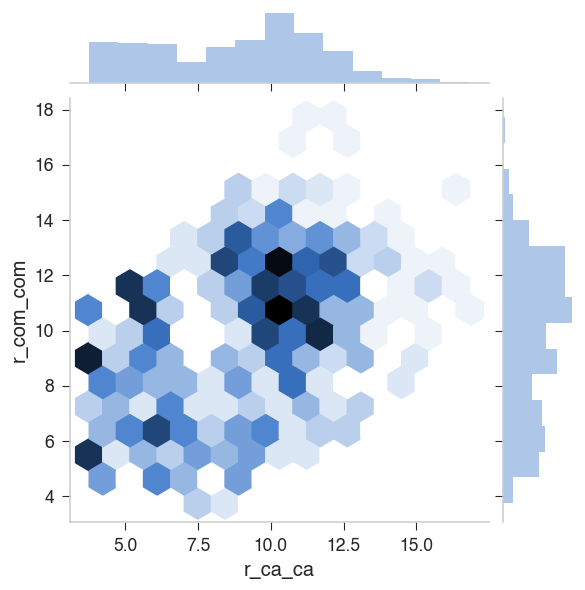

In [291]:
sns.jointplot("r_ca_ca", "r_com_com", kind='hex', data=d_subset)

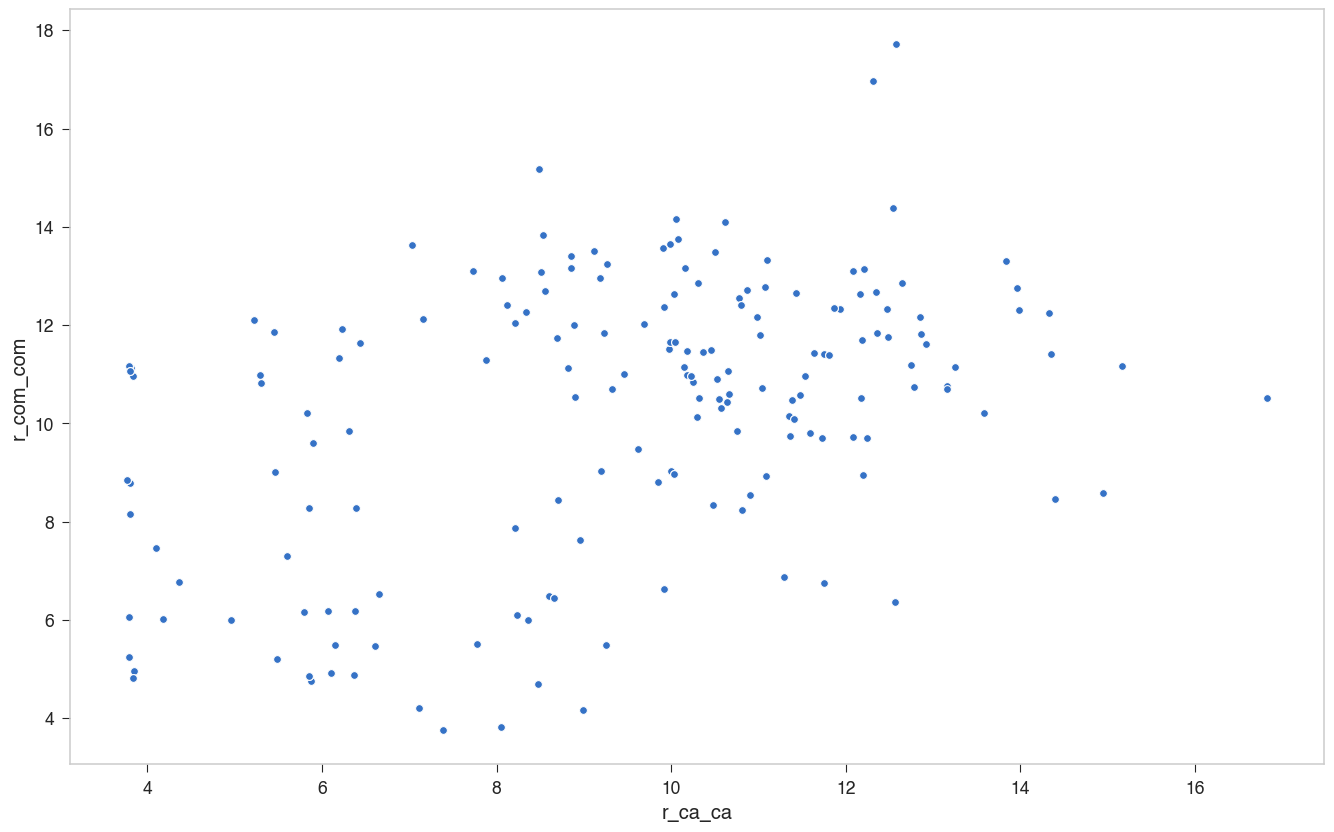

In [270]:
sns.scatterplot("r_ca_ca", "r_com_com", data=d_subset)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a25cc7c88>]],
      dtype=object)

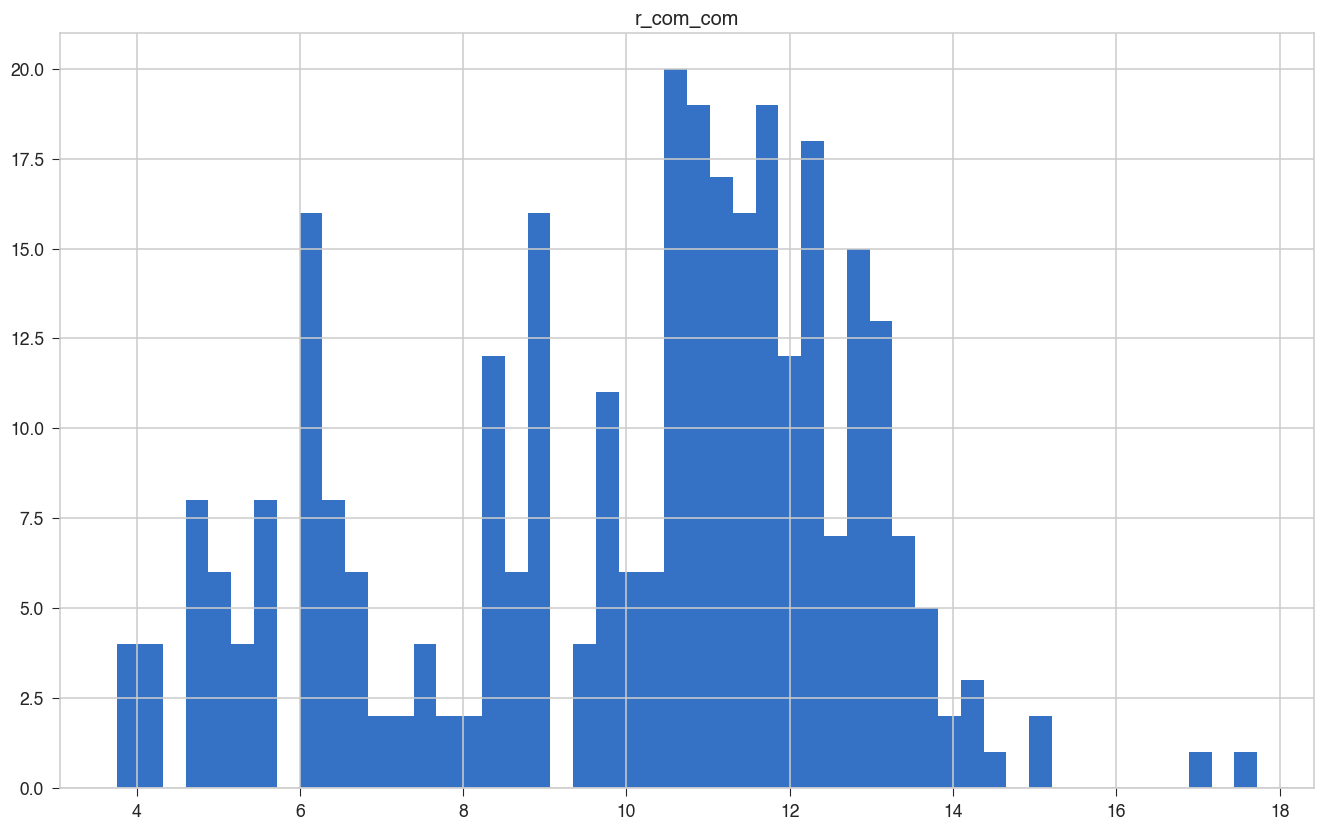

In [268]:
d_subset.hist("r_com_com", bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2556def0>]],
      dtype=object)

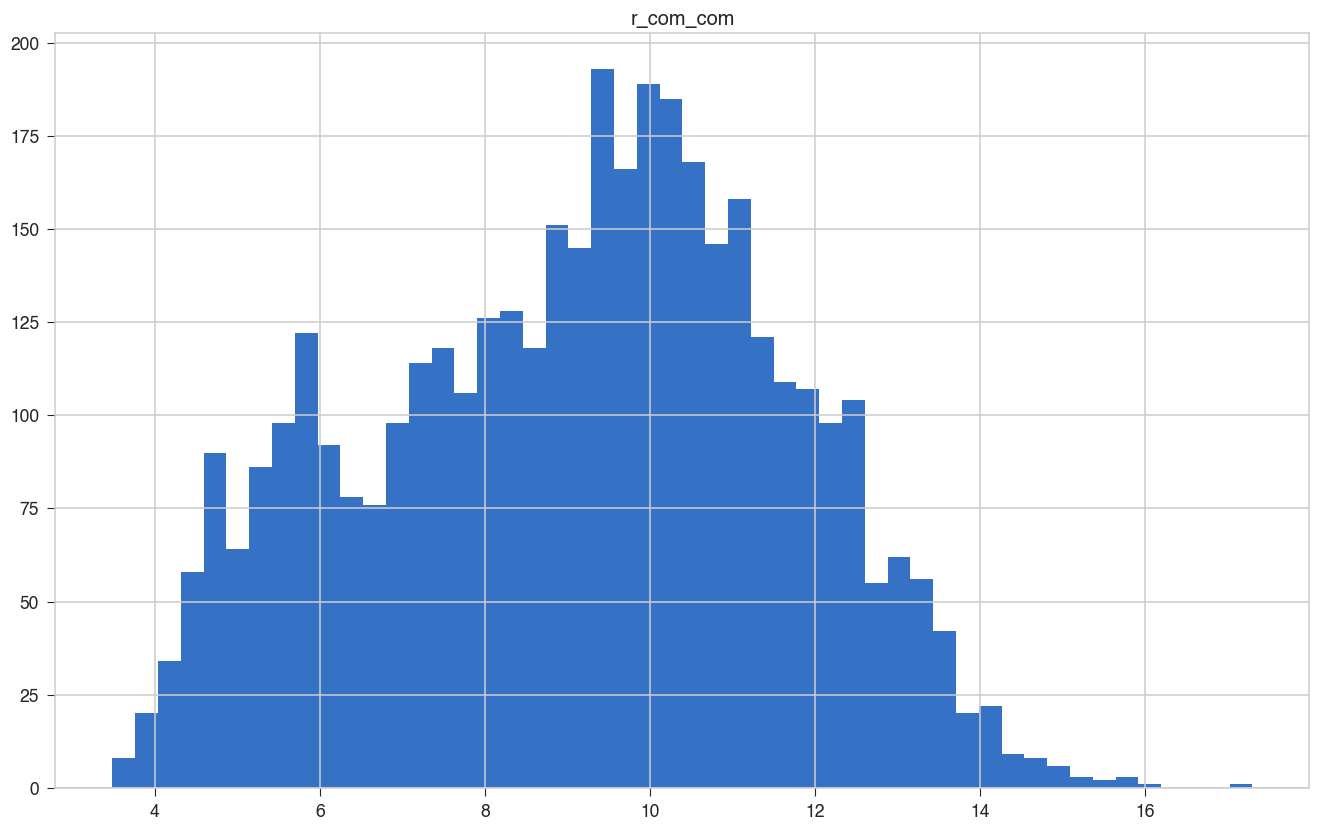

In [254]:
data.hist("r_com_com", bins=50)

In [ ]:
np.clip(cb_density, 0, 10)
freq, bins = np.histogram(cb_density, bins=100, range=(0,10))

In [320]:
%%time
info = []
skipped_residues_count = 0
# for i, a in enumerate(a_list[:500]):
for i, a in enumerate(a_list):
    pdb = a.split("/")[-1].split(".")[0]
    structure = parser.get_structure("x", a)
    for res in structure.get_residues():
        resName = res.get_resname()
        set_of_all_non_H_atoms = get_all_non_H_atoms(res)
        if resName == "GLY":
            continue
        if set_of_all_non_H_atoms != res_set[resName]:
            skipped_residues_count += 1
            # print("skip", resName, res.get_id(), "atom not complete", set_of_all_non_H_atoms, "should be ", res_set[resName])
            continue
        x, r = get_x_distance_based(res, alpha=0.001)
        info.append([pdb, res.id[1], resName, x[0], x[1], x[2], r])
print("skipped_residues_count", skipped_residues_count)

skipped_residues_count 1816
CPU times: user 19.8 s, sys: 731 ms, total: 20.6 s
Wall time: 49.9 s


In [321]:
data = pd.DataFrame(info, columns=["Protein", "id", "ResName", "r1", "r2", "r3", "r"])

In [322]:
data.to_csv("/Users/weilu/Research/data/survey_represent_x_com_complete.csv")

In [323]:
data = pd.read_csv("/Users/weilu/Research/data/survey_represent_x_com_complete.csv", index_col=0)

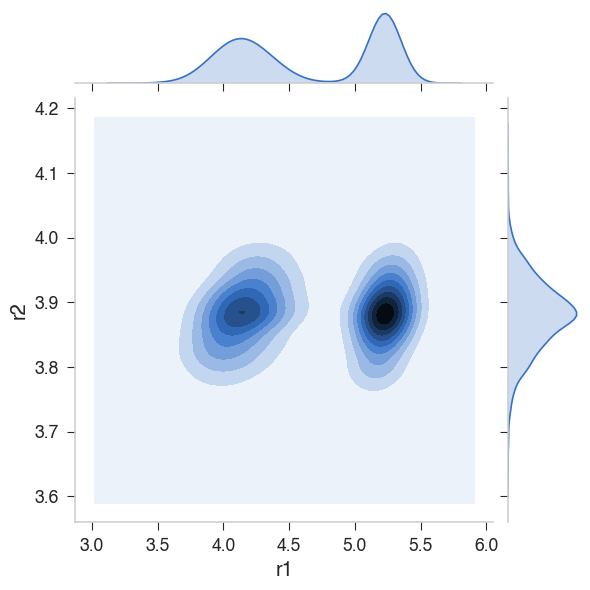

In [328]:
data_res = data.query("ResName == 'TYR'").reset_index(drop=True)
sns.jointplot("r1", "r2", kind="kde", data=data_res)
# plt.show()

In [331]:
fig = px.scatter_3d(data_res, x='r1', y='r2', z='r3', color="r")
fig.show()

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

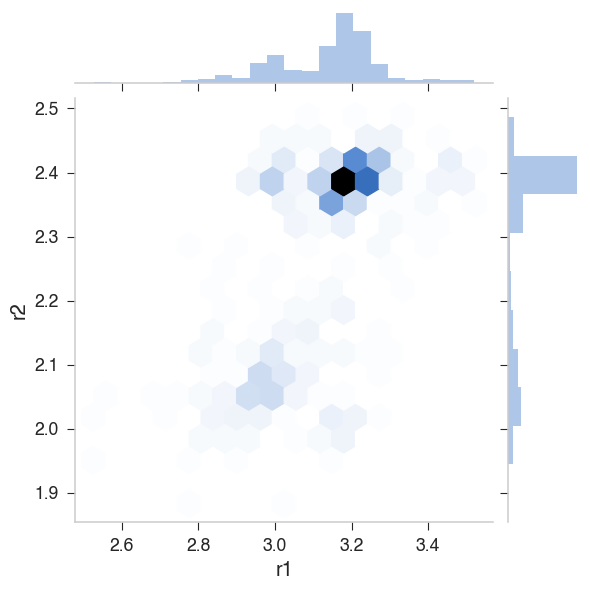

In [230]:
data_res = data.query("ResName == 'ILE'").reset_index(drop=True)
sns.jointplot("r1", "r2", kind='hex', data=data_res)
# plt.show()

In [231]:
# ILE

import plotly.express as px
fig = px.scatter_3d(data_res, x='r1', y='r2', z='r3', color="r")
fig.show()

In [298]:
# TYR
import plotly.express as px
fig = px.scatter_3d(data_res, x='r1', y='r2', z='r3', color="r")
fig.show()

In [299]:
data_res = data.query("ResName == 'TRP'").reset_index(drop=True)
# sns.jointplot("r1", "r2", kind='hex', data=data_res)
# TRP
fig = px.scatter_3d(data_res, x='r1', y='r2', z='r3', color="r")
fig.show()

In [232]:
%%time
info = []
skipped_residues_count = 0
for i, a in enumerate(a_list[:100]):
    pdb = a.split("/")[-1].split(".")[0]
    structure = parser.get_structure("x", a)
    for res in structure.get_residues():
        resName = res.get_resname()
        set_of_all_non_H_atoms = get_all_non_H_atoms(res)
        if resName == "GLY":
            continue
        if set_of_all_non_H_atoms != res_set[resName]:
            skipped_residues_count += 1
            # print("skip", resName, res.get_id(), "atom not complete", set_of_all_non_H_atoms, "should be ", res_set[resName])
            continue
        x, r = get_x_vector_based(res, alpha=0.001)
        info.append([pdb, res.id[1], resName, x[0], x[1], x[2], r])
print("skipped_residues_count", skipped_residues_count)

skipped_residues_count 209
CPU times: user 2.82 s, sys: 89.2 ms, total: 2.91 s
Wall time: 4.18 s


In [233]:
data = pd.DataFrame(info, columns=["Protein", "id", "ResName", "x", "y", "z", "r"])

In [235]:
data_res = data.query("ResName == 'ILE'").reset_index(drop=True)

import plotly.express as px
fig = px.scatter_3d(data_res, x='x', y='y', z='z')
fig.show()

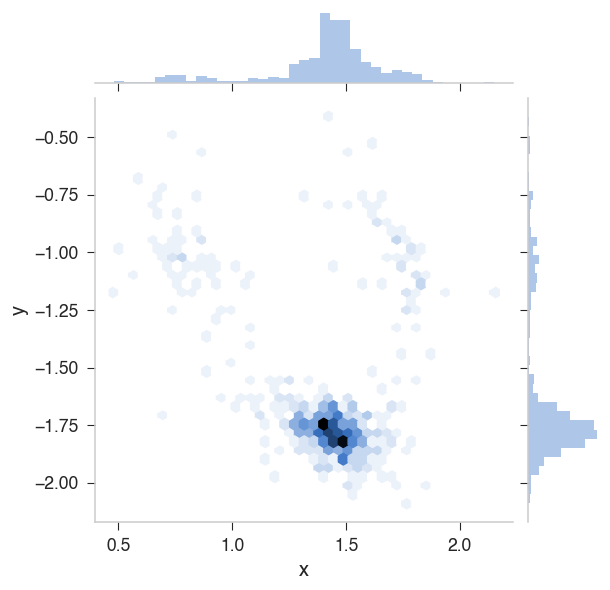

In [219]:
data_res = data.query("ResName == 'ILE'").reset_index(drop=True)
sns.jointplot("x", "y", kind='hex', data=data_res)
# plt.show()

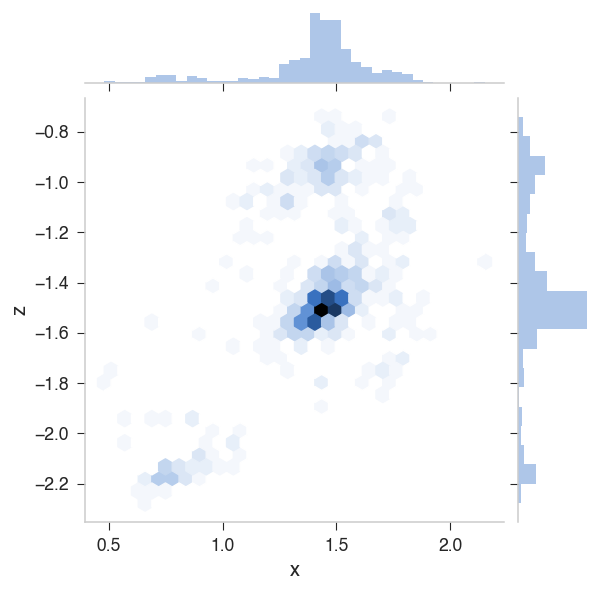

In [220]:
data_res = data.query("ResName == 'ILE'").reset_index(drop=True)
sns.jointplot("x", "z", kind='hex', data=data_res)
# plt.show()

In [214]:
get_x_vector_based(res)

(array([ 0.24322264, -1.20302761, -4.23105961]), 0)

In [173]:
res

<Residue ARG het=  resseq=271 icode= >

In [209]:

n = res["N"].get_coord()
ca = res["CA"].get_coord()
c = res["C"].get_coord()

x_com = get_side_chain_center_of_mass(res.get_atoms())
ca_x_com = x_com - ca

n_ca = ca - n
ca_c = c - ca
x3 = np.cross(n_ca, ca_c)

n_ca_unit = n_ca / np.linalg.norm(n_ca)
ca_c_unit = ca_c / np.linalg.norm(ca_c)
x3_unit = x3 / np. linalg.norm(x3)

A = np.zeros((3,3))
A[:,0] = n_ca_unit
A[:,1] = ca_c_unit
A[:,2] = x3_unit

A_inv = np.linalg.inv(A)
x = A_inv.dot(ca_x_com)

In [210]:
x

array([ 0.24322264, -1.20302761, -4.23105961])

In [194]:
x[0] * n_ca_unit + x[1] * ca_c_unit + x[2] * x3_unit

array([ 3.2382128 ,  0.96548057, -2.786955  ], dtype=float32)

In [195]:
ca_x_com

array([ 3.23821271,  0.9654806 , -2.78695511])

In [197]:
from scipy.spatial.transform import Rotation as R
r = R.from_quat([0, 0, np.sin(np.pi/4), np.cos(np.pi/4)])
r

In [198]:
r.apply(n_ca_unit)

array([0.43286487, 0.62318665, 0.65135741])

In [202]:
A_inv = r.apply(A.T).T

In [206]:
x = A_inv.dot(r.apply(ca_x_com))

In [207]:
x[0] * n_ca_unit + x[1] * ca_c_unit + x[2] * x3_unit

array([-2.2808218 ,  2.440909  , -0.22520131], dtype=float32)

In [208]:
r.apply(ca_x_com)

array([-0.9654806 ,  3.23821271, -2.78695511])

In [182]:
n_ca

array([ 0.9069996 , -0.63000107,  0.94799995], dtype=float32)

In [187]:
ca_c

array([0.26500034, 0.8730011 , 1.2160001 ], dtype=float32)

In [183]:
n_ca_unit

array([ 0.62318665, -0.43286487,  0.6513574 ], dtype=float32)

In [186]:
n_ca_unit.dot(x3)

0.0

In [185]:
n_ca_unit.dot(x_com)

-15.681311883534361

In [184]:
A

array([[ 0.62318665, -0.43286487,  0.65135741],
       [ 0.17431922,  0.57426673,  0.79989403],
       [-0.77908391, -0.41635478,  0.4686971 ]])

In [84]:
data = pd.DataFrame(info, columns=["Protein", "id", "ResName", "x", "y", "z", "r"])

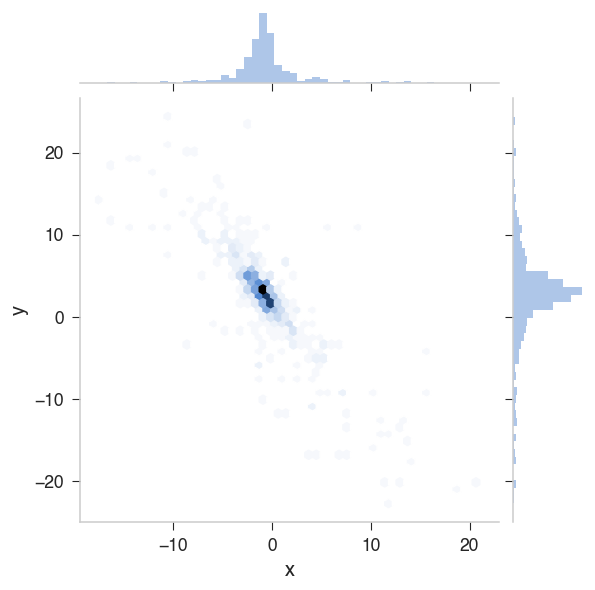

In [164]:
data_res = data.query("ResName == 'ILE'").reset_index(drop=True)
data_filtered = data_res.query("abs(y) < 10 and abs(x) < 10")
sns.jointplot("x", "y", kind='hex', data=data_res)
# plt.show()

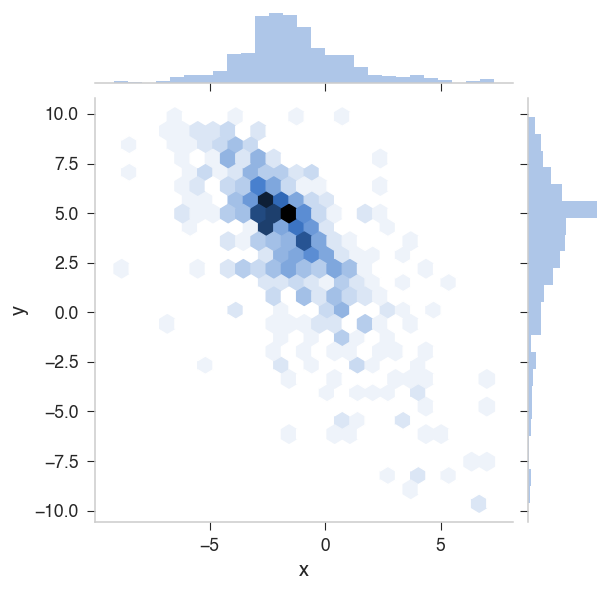

In [146]:
data_res = data.query("ResName == 'ARG'").reset_index(drop=True)
data_filtered = data_res.query("abs(y) < 10 and abs(x) < 10")
sns.jointplot("x", "y", kind='hex', data=data_filtered)
# plt.show()

array([[ 1.65689976,  4.80961033, -5.34607806],
       [-8.63029918, 12.75947908, -3.29953343],
       [-4.06695797,  9.46796152, -4.33477461],
       ...,
       [-2.45563084,  5.56525263, -2.12490558],
       [-2.24415797,  4.28690427, -1.02217866],
       [-2.54058323,  5.74260799, -2.26415653]])

In [151]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X = data_res[["x", "y", "z"]].values
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [152]:
print(pca.explained_variance_ratio_)

print(pca.singular_values_)

[0.81709676 0.18253884]
[283.00041095 133.76052632]


In [153]:
pca.components_

array([[ 0.40234224, -0.81465833,  0.41767515],
       [ 0.72521028,  0.00516783, -0.68850806]])

In [156]:
pca.mean_

array([-1.40049734,  3.49781227, -1.11634265])

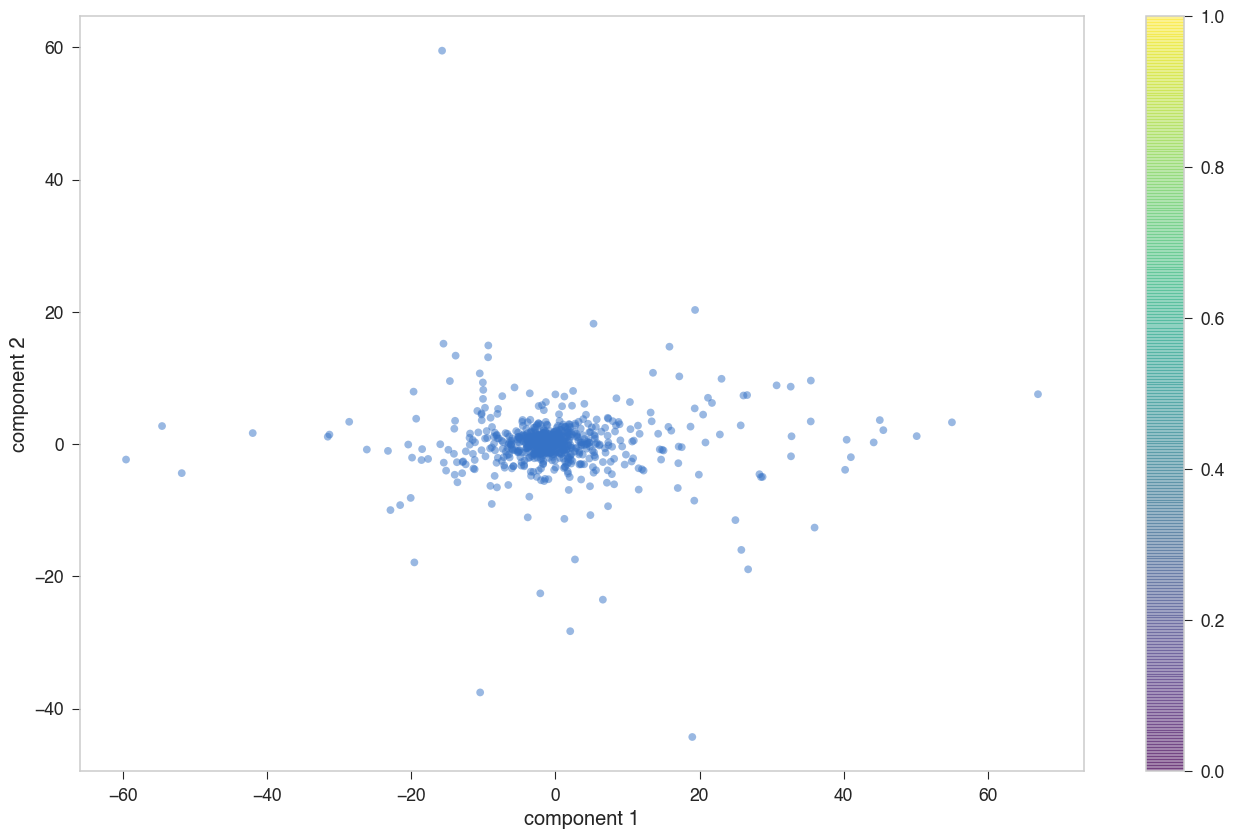

In [163]:
projected = pca.fit_transform(X)
plt.scatter(projected[:, 0], projected[:, 1],
            edgecolor='none', alpha=0.5)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

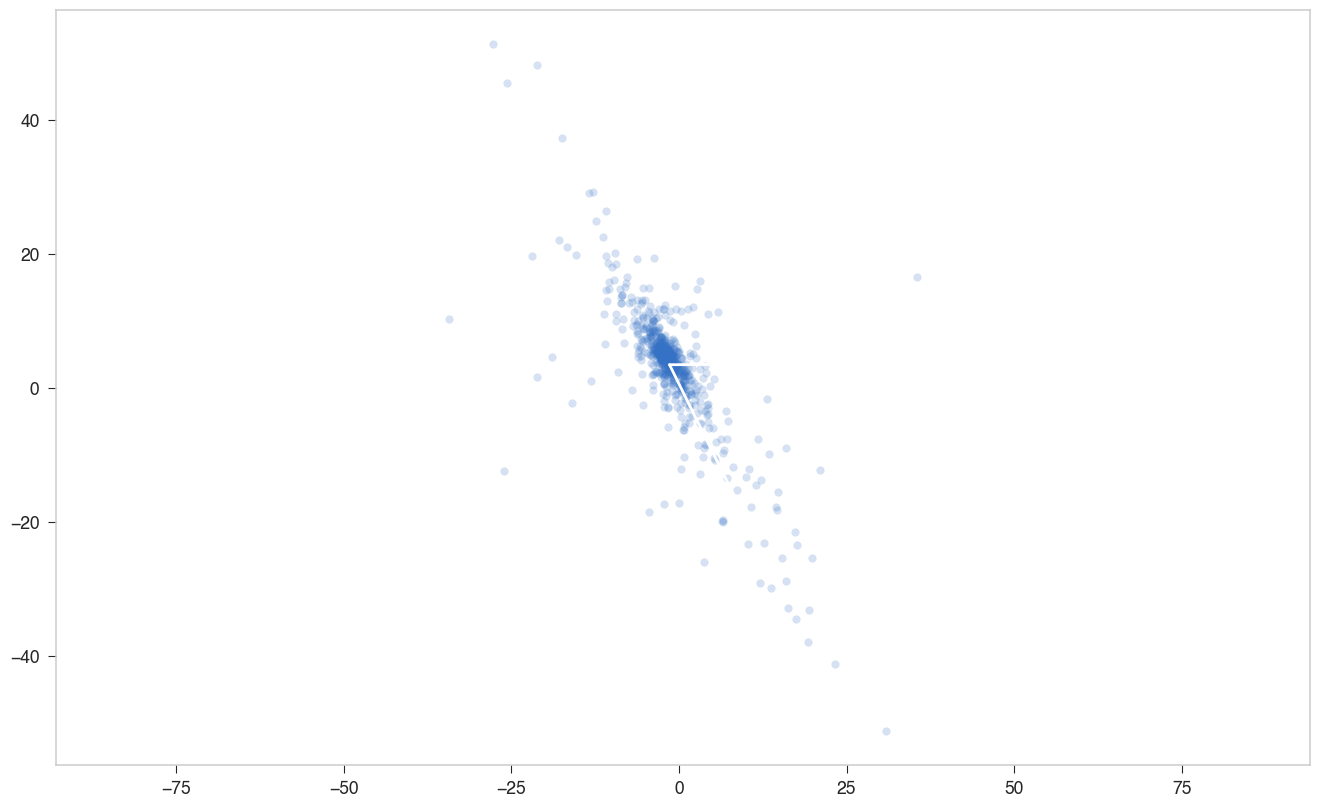

In [157]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector[:2] * 3 * np.sqrt(length)
    draw_vector(pca.mean_[:2], pca.mean_[:2] + v)
plt.axis('equal');

In [147]:
data_res.shape

(684, 7)

In [148]:
data_filtered.shape

(549, 7)

In [133]:
data.shape

(9187, 7)

In [134]:
from sklearn.decomposition import PCA
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
pca = PCA(n_components=2)
pca.fit(X)

print(pca.explained_variance_ratio_)

print(pca.singular_values_)

[0.99244289 0.00755711]
[6.30061232 0.54980396]


In [ ]:
pca.singular_values_

In [138]:
pca.components_

array([[-0.83849224, -0.54491354],
       [ 0.54491354, -0.83849224]])

In [140]:
(0.83849224**2 + 0.5449135**2)**0.5

0.9999999795112336

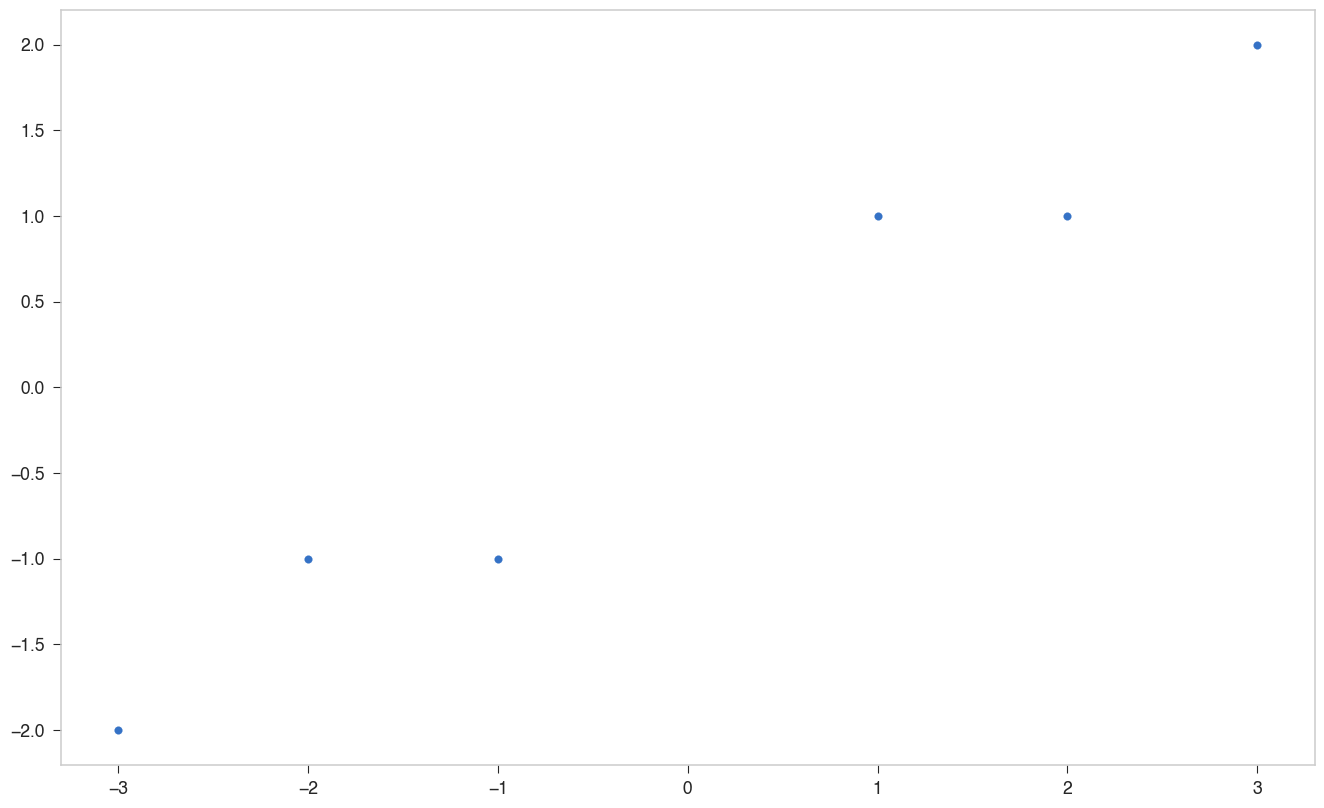

In [137]:
plt.scatter(X[:,0], X[:,1])

In [135]:
%%time
info = []
skipped_residues_count = 0
for i, a in enumerate(a_list[:100]):
    pdb = a.split("/")[-1].split(".")[0]
    structure = parser.get_structure("x", a)
    for res in structure.get_residues():
        resName = res.get_resname()
        set_of_all_non_H_atoms = get_all_non_H_atoms(res)
        if resName == "GLY":
            continue
        if set_of_all_non_H_atoms != res_set[resName]:
            skipped_residues_count += 1
            # print("skip", resName, res.get_id(), "atom not complete", set_of_all_non_H_atoms, "should be ", res_set[resName])
            continue
        x, r = get_x_with_regularization(res, alpha=0.001)
        info.append([pdb, res.id[1], resName, x[0], x[1], x[2], r])
print("skipped_residues_count", skipped_residues_count)

array([[-1, -1],
       [-2, -1],
       [-3, -2],
       [ 1,  1],
       [ 2,  1],
       [ 3,  2]])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2699e208>]],
      dtype=object)

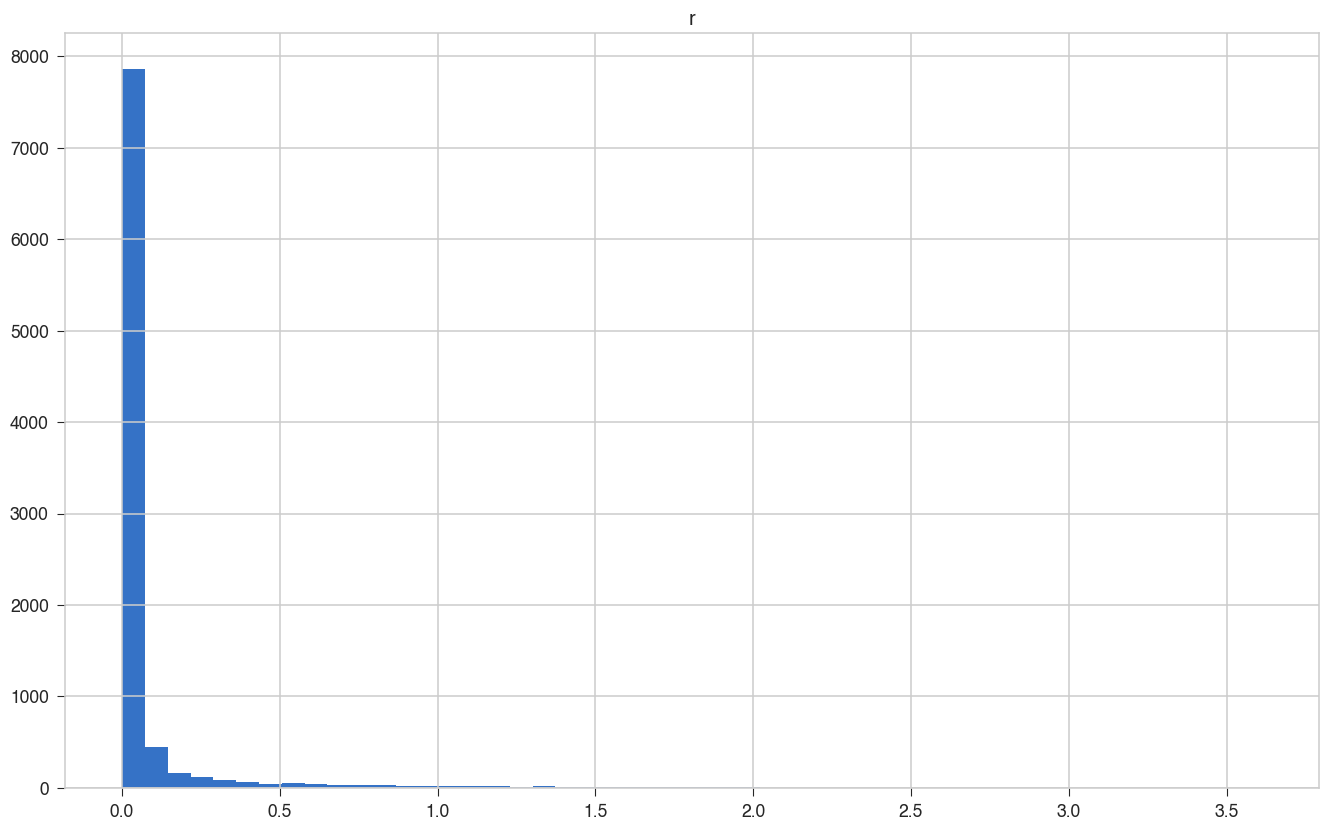

In [103]:
data.hist("r", bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a26954048>]],
      dtype=object)

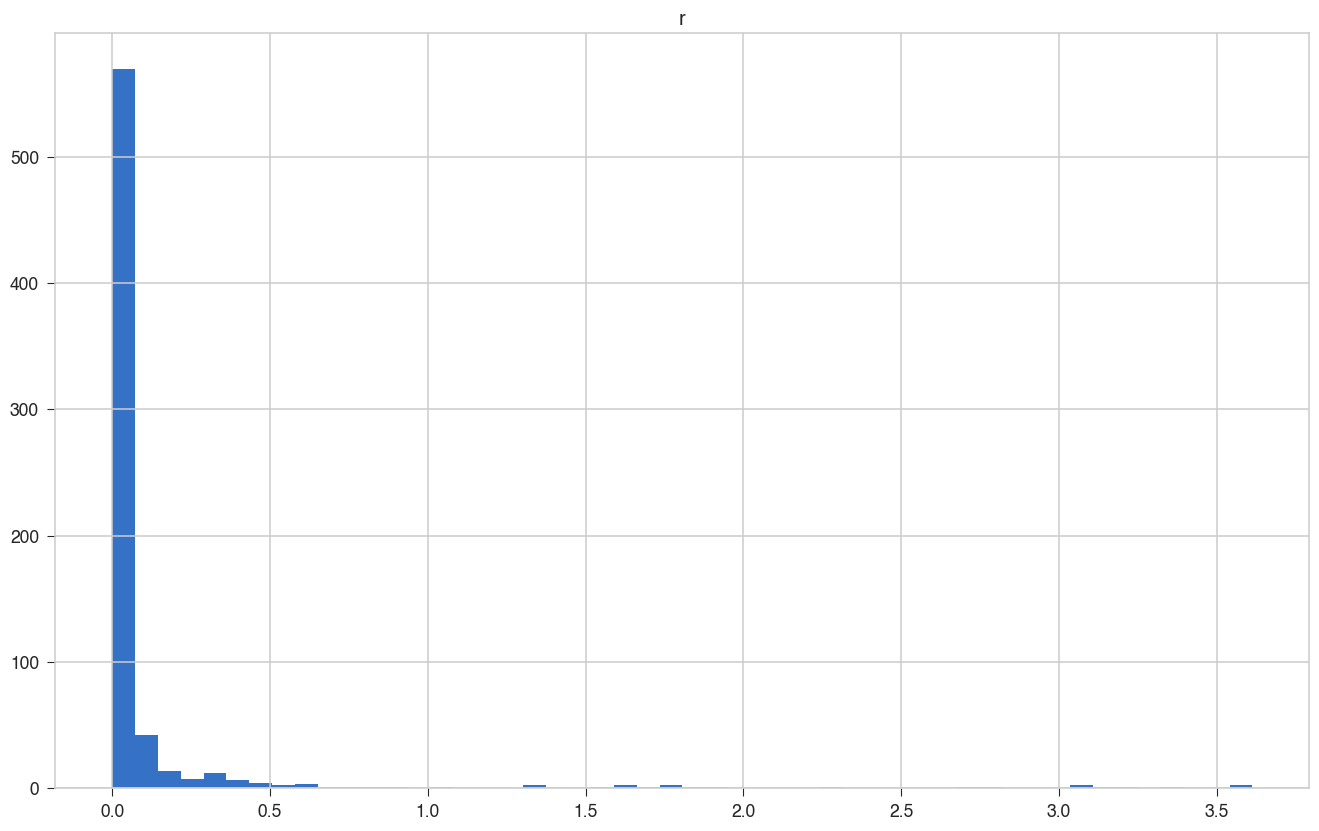

In [105]:
data.query("ResName == 'ARG'").hist("r", bins=50)

In [141]:
data.sort_values("r").query("r > 1.5").shape

(70, 7)

In [108]:
data.shape

(9187, 7)

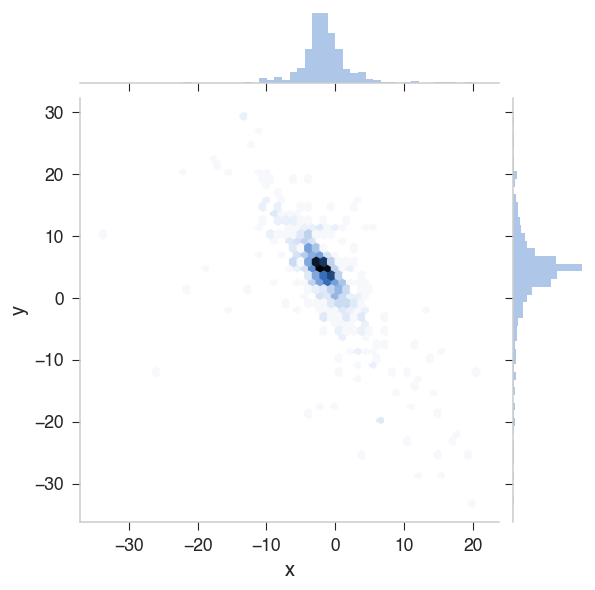

In [111]:
data_res = data.query("ResName == 'ARG' and r < 1").reset_index(drop=True)
sns.jointplot("x", "y", kind='hex', data=data_res)
# plt.show()

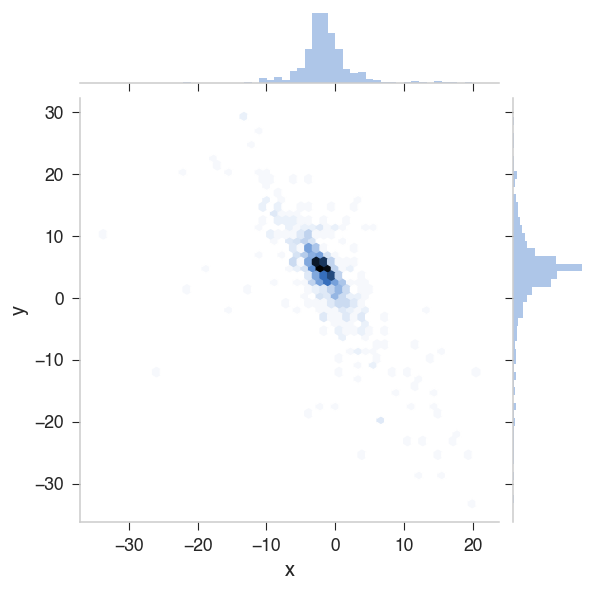

In [110]:
data_res = data.query("ResName == 'ARG' and r < 1.5").reset_index(drop=True)
sns.jointplot("x", "y", kind='hex', data=data_res)
# plt.show()

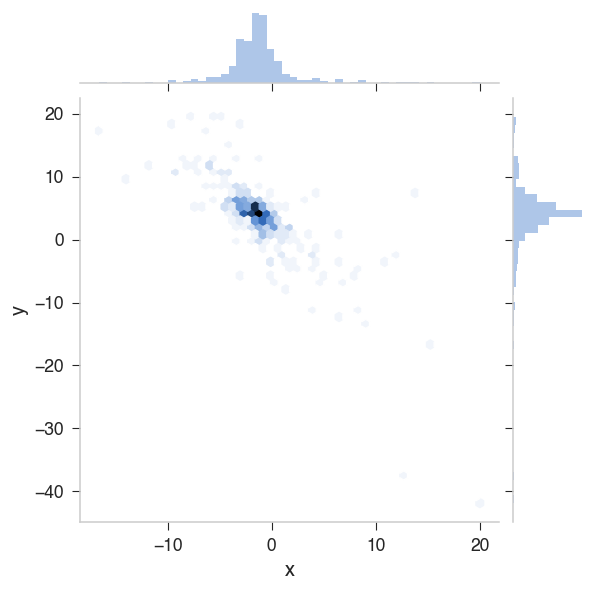

In [102]:
data_res = data.query("ResName == 'PHE'").reset_index(drop=True)
sns.jointplot("x", "y", kind='hex', data=data_res)
# plt.show()

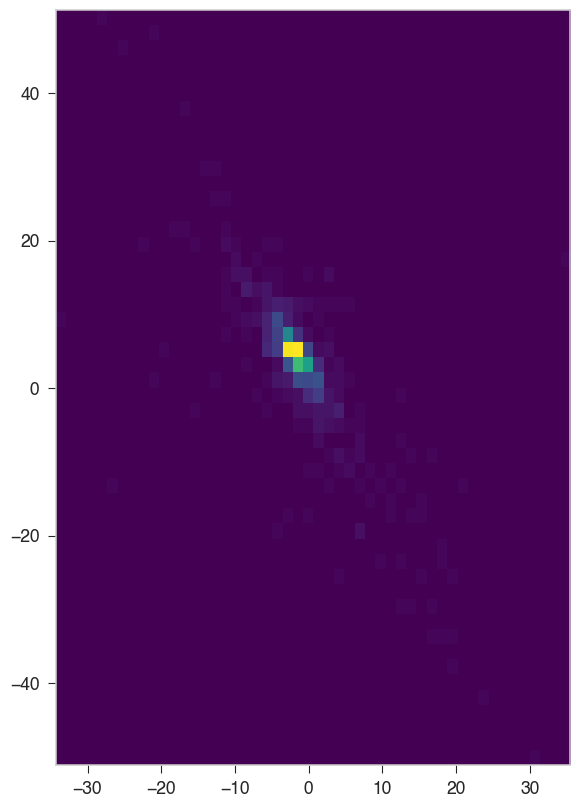

In [99]:
data_res = data.query("ResName == 'ARG'").reset_index(drop=True)
heatmap, xedges, yedges = np.histogram2d(data_res["x"], data_res["y"], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()

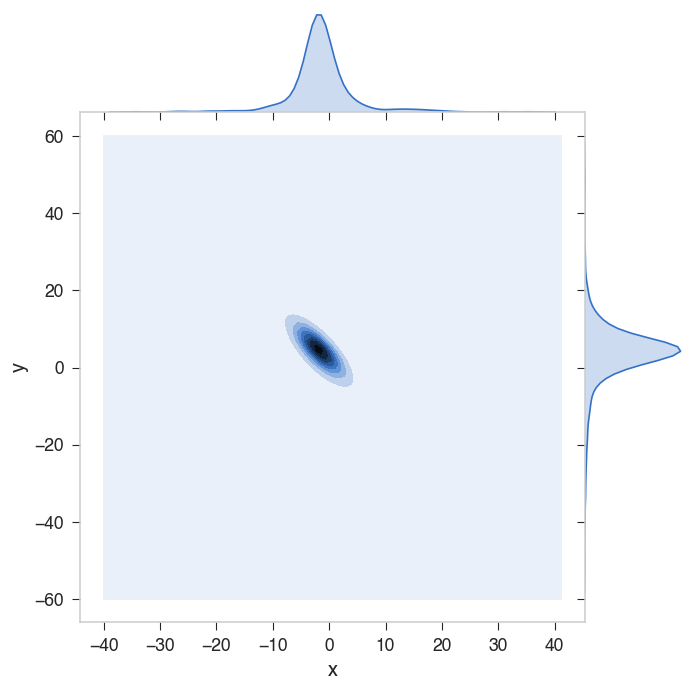

In [95]:
# alpha=0.001
data_leu = data.query("ResName == 'ARG'")
g = sns.jointplot("x", "y", kind="kde", height=7, space=0, data=data_leu)

In [98]:
np.random.randn(50, 20).shape

(50, 20)

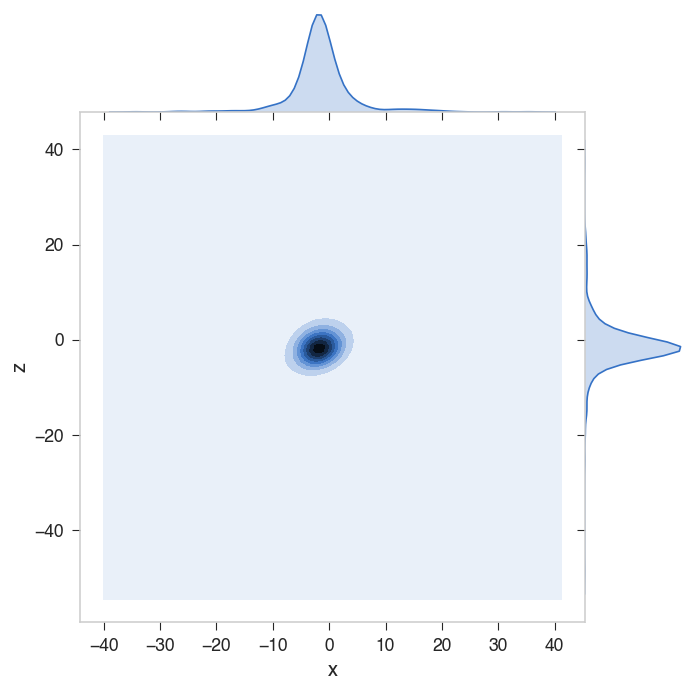

In [96]:
# alpha=0.001
data_leu = data.query("ResName == 'ARG'")
g = sns.jointplot("x", "z", kind="kde", height=7, space=0, data=data_leu)

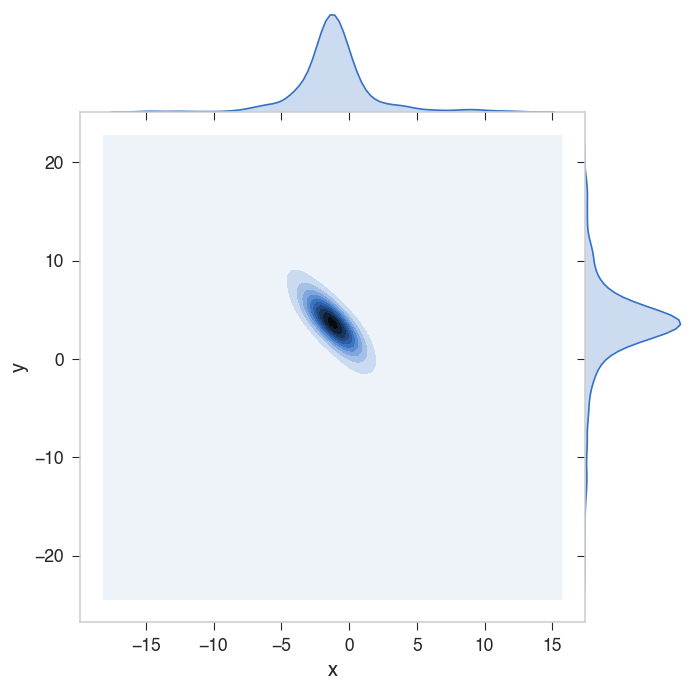

In [86]:
# alpha=0.001
data_leu = data.query("ResName == 'LEU'")
g = sns.jointplot("x", "y", kind="kde", height=7, space=0, data=data_leu)

In [ ]:
# %%time
# info = []
# skipped_residues_count = 0
# for i, a in enumerate(a_list[:100]):
#     pdb = a.split("/")[-1].split(".")[0]
#     structure = parser.get_structure("x", a)
#     for res in structure.get_residues():
#         resName = res.get_resname()
#         set_of_all_non_H_atoms = get_all_non_H_atoms(res)
#         if resName == "GLY":
#             continue
#         if set_of_all_non_H_atoms != res_set[resName]:
#             skipped_residues_count += 1
#             # print("skip", resName, res.get_id(), "atom not complete", set_of_all_non_H_atoms, "should be ", res_set[resName])
#             continue
#         x = get_x(res)
#         info.append([pdb, res.id[1], resName, x[0], x[1], x[2]])
# print("skipped_residues_count", skipped_residues_count)

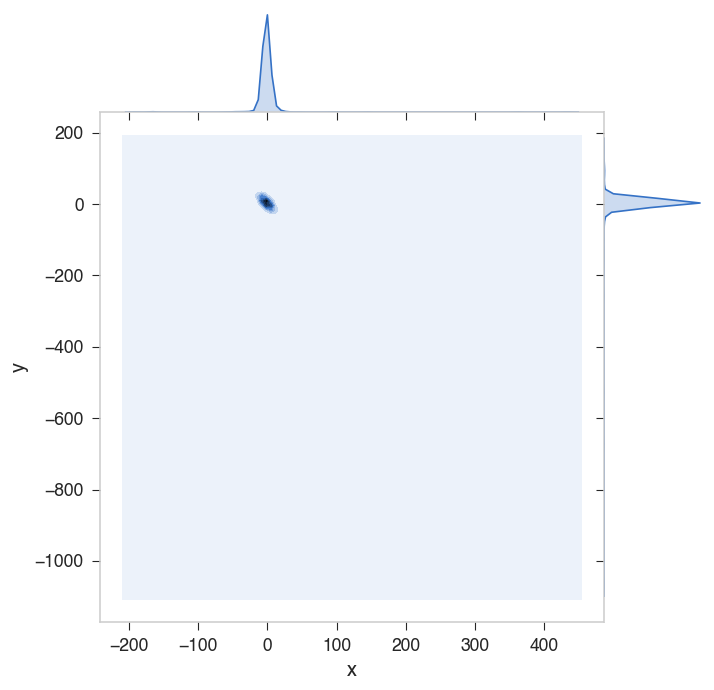

In [82]:
# data = pd.DataFrame(info, columns=["Protein", "id", "ResName", "x", "y", "z"])
# data.to_csv("/Users/weilu/Research/data/survey_side_chain_without_regularization.csv")
pd.read_csv("/Users/weilu/Research/data/survey_side_chain_without_regularization.csv", index_col=0)
data_leu = data.query("ResName == 'LEU'")
g = sns.jointplot("x", "y", kind="kde", height=7, space=0, data=data_leu)

In [ ]:
# debug

In [20]:
data_leu.sort_values("x").head()

,Protein,id,ResName,x,y,z
412,3ri2A00,40,LEU,-188.804494,-672.628879,902.648769
9047,4ezbA02,185,LEU,-168.161743,97.630573,66.668412
6206,1v1gA00,122,LEU,-165.055649,80.005997,92.428031
2233,2vuwA02,745,LEU,-164.443756,93.145782,55.941395
5112,1z6tA04,437,LEU,-104.980567,152.425618,-44.754021


In [113]:

a = "/Users/weilu/Research/server/feb_2020/energy_evaluations_and_database_survey/my_CATH_database/2xo2A04.pdb"
structure = parser.get_structure("x", a)
res_list = list(structure.get_residues())

In [118]:
res = res_list[23]


In [132]:
res

<Residue ARG het=  resseq=271 icode= >

In [124]:
x_com = get_side_chain_center_of_mass(res.get_atoms())

n = res["N"].get_coord()
ca = res["CA"].get_coord()
c = res["C"].get_coord()

A = np.zeros((3,3))
A[:,0] = n
A[:,1] = ca
A[:,2] = c

A_inv = np.linalg.inv(A)
x = A_inv.dot(x_com)

alpha = 0.001
A_inv_regularized = np.linalg.inv(A.T.dot(A) + alpha*np.eye(3)).dot(A.T)
x_regularized = A_inv_regularized.dot(x_com)
r = dis(A.dot(x_regularized), x_com)

In [120]:
x

array([ 132.43510195, -270.34442241,  131.38163672])

In [121]:
A.dot(x)

array([-8.52378737, 27.15748004,  2.12804485])

In [128]:
A

array([[-12.66899967, -11.76200008, -11.49699974],
       [ 26.8220005 ,  26.19199944,  27.06500053],
       [  3.96700001,   4.91499996,   6.13100004]])

In [127]:
x_com

array([-8.52378737, 27.15748004,  2.12804485])

In [129]:
dis(n, x_com)

4.547206573188637

In [130]:
dis(ca, x_com)

4.380101959272891

In [131]:
dis(c, x_com)

4.987203078065462

In [125]:
r

3.6127000438641286

In [126]:
A.dot(x_regularized)

array([-11.30963811,  25.59170412,   3.81297305])

In [21]:
a = "/Users/weilu/Research/server/feb_2020/energy_evaluations_and_database_survey/my_CATH_database/3ri2A00.pdb"
structure = parser.get_structure("x", a)

In [27]:
res = res_list[37]

In [28]:
get_x(res)

array([-188.8044942 , -672.62887875,  902.64876887])

In [50]:
x_com = get_side_chain_center_of_mass(res.get_atoms())

n = res["N"].get_coord()
ca = res["CA"].get_coord()
c = res["C"].get_coord()

A = np.zeros((3,3))
A[:,0] = n
A[:,1] = ca
A[:,2] = c

A_inv = np.linalg.inv(A)
x = A_inv.dot(x_com)

In [31]:
A

array([[11.89900017, 12.82600021, 12.06299973],
       [36.13999939, 35.        , 33.68000031],
       [ 4.7329998 ,  4.704     ,  4.50199986]])

In [32]:
A_inv

array([[  15.17926736,   17.60544306, -172.38090864],
       [  58.10582391,   62.162693  , -620.73970391],
       [ -76.67109639,  -83.4606571 ,  830.03964716]])

In [33]:
c

array([12.063, 33.68 ,  4.502], dtype=float32)

In [34]:
x_com

array([14.92900023, 35.80574957,  6.06674993])

In [51]:
x

array([-188.8044942 , -672.62887875,  902.64876887])

In [70]:
A_inv_regularized = np.linalg.inv(A.T.dot(A) + 0.001*np.eye(3)).dot(A.T)
x_regularized = A_inv_regularized.dot(x_com)

In [71]:
A_inv_regularized

array([[-0.77884945,  0.3091532 , -0.1970976 ],
       [ 0.61928037, -0.13867967, -0.51832717],
       [ 0.19192516, -0.15822552,  0.75306115]])

In [76]:
x_com 

array([14.92900023, 35.80574957,  6.06674993])

In [77]:
A.dot(x_regularized)

array([15.02525481, 35.9136612 ,  5.00114547])

In [74]:
dis(A.dot(x_regularized), x_com)

1.0753709703770111

In [58]:
dis(A.dot(x_regularized), x_com)

1.6364966964587682

In [52]:
dis(A.dot(x), x_com)

5.581610842781314e-12

In [22]:
for res in structure.get_residues():
    resName = res.get_resname()
    set_of_all_non_H_atoms = get_all_non_H_atoms(res)
    if resName == "GLY":
        continue
    if set_of_all_non_H_atoms != res_set[resName]:
        skipped_residues_count += 1
        # print("skip", resName, res.get_id(), "atom not complete", set_of_all_non_H_atoms, "should be ", res_set[resName])
        continue
    x = get_x(res)
    print([pdb, res.id[1], resName, x[0], x[1], x[2]])

['2kelA00', 0, 'ALA', -1.3352631101430124, 2.727835000894978, -0.3052830057350642]
['2kelA00', 2, 'ALA', -25.400825810867214, 30.580359390071745, -5.550523359595847]
['2kelA00', 4, 'ASP', 0.2705502251913243, 0.588117837058423, 0.02560198778930811]
['2kelA00', 5, 'ASP', 2.340036308456078, 2.8924895046301815, -3.8856779242848702]
['2kelA00', 6, 'ILE', -2.469774510980331, 5.118434561095732, -1.7317562157884403]
['2kelA00', 7, 'VAL', -0.9682767211470962, 2.664665925172341, -0.7401246264184911]
['2kelA00', 8, 'SER', -0.21581980424693015, -3.057051477398254, 3.9958915663714976]
['2kelA00', 9, 'SER', 414.8791789405225, -261.09219620467775, -129.85431462781452]
['2kelA00', 11, 'VAL', -0.7545254355339206, 2.0581263257920783, -0.34957363655225615]
['2kelA00', 12, 'LEU', -6.562737955118603, -7.01531944016299, 13.769925964533499]
['2kelA00', 13, 'GLU', -1.82994163574494, 4.643189483371186, -1.8222133083950993]
['2kelA00', 14, 'LEU', -1.2934641950427328, 3.833409797150778, -1.5737821918513935]
['2k

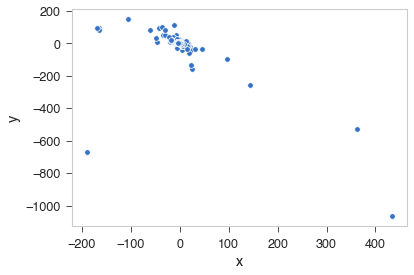

In [276]:
sns.scatterplot("x", "y", data=a)

In [261]:
data.shape

(9187, 5)

In [265]:
data["ResName"].value_counts()

LEU    1139
ALA     881
GLU     791
ARG     684
VAL     620
SER     575
LYS     567
ASP     561
ILE     527
THR     503
GLN     363
PHE     355
PRO     353
ASN     350
TYR     315
HIS     201
MET     142
TRP     140
CYS     120
Name: ResName, dtype: int64

In [218]:
a

7     [0.5773658019737482, -1.0065613401403937, 1.37...
20    [-0.10880335280807074, 2.2502633470559914, -1....
36    [-1.3777758839592469, 4.582999960404106, -2.22...
44    [-6.056005858135052, 19.147790518783268, -11.8...
Name: x, dtype: object

In [197]:
res.get_full_id()

('x', 0, 'C', (' ', 158, ' '))

In [199]:
res.get_id()

(' ', 158, ' ')

In [ ]:
res.

In [161]:
x_com = get_side_chain_center_of_mass(res.get_atoms())

n = res["N"].get_coord()
ca = res["CA"].get_coord()
c = res["C"].get_coord()

A = np.zeros((3,3))
A[:,0] = n
A[:,1] = ca
A[:,2] = c

A_inv = np.linalg.inv(A)
x = A_inv.dot(x_com)


In [164]:
get_x(res)

array([-0.85647769,  3.72195722, -1.84587391])

In [156]:
x

array([-0.85647769,  3.72195722, -1.84587391])

In [159]:
x[0]*n + x[1]*ca + x[2]*c

array([10.269524, 17.78884 ,  9.384737], dtype=float32)

In [158]:
x[0]*n + x[1]*ca + x[2]*c - x_com

array([-1.15583163e-06,  1.54376988e-07, -9.92085159e-07])

In [120]:
r_gamma = 2.63
x_com_computed = res["CA"].get_coord() + r_gamma * (res["CB"].get_coord() - res["CA"].get_coord())/(res["CB"] - res["CA"])

In [116]:
dis(res["CA"].get_coord(), x_com)

2.6658432923604827

In [121]:
dis(x_com_computed, x_com)

2.2669587212437174

In [122]:
dis(res["CB"].get_coord(), x_com)

2.0684519135763497

In [ ]:


name_list_set = get_all_non_H_atoms(res)
print(res.get_resname(), name_list_set)

In [181]:
total = np.array([0., 0., 0.])
total_mass = 0
for atom in atoms:
    if atom.get_name() in ["N", "CA", "C", "O"]:
        continue
    if atom.element == "H":
        continue
    total += atom.mass * atom.get_coord()
    total_mass += atom.mass
    print(atom.get_name(), atom.get_coord())
x_com = total / total_mass

CB [ 8.74  18.406 10.633]
CG [ 9.362 18.514  9.251]
CD [10.605 17.651  9.104]
OE1 [11.599 17.858  9.803]
NE2 [10.553 16.677  8.192]


In [166]:
name_list = []
for atom in atoms:
    name = atom.get_name()
    if atom.element == "H":
        continue
    name_list.append(name)
print(res.get_resname(), set(name_list))

GLN {'CA', 'CB', 'CG', 'CD', 'OE1', 'NE2', 'N', 'O', 'C'}


In [126]:
res["CA"].get_coord()

array([ 8.307, 16.983, 10.999], dtype=float32)

In [123]:
res["CB"].get_coord()

array([ 8.74 , 18.406, 10.633], dtype=float32)

In [124]:
x_com_computed

array([ 9.050438, 19.426218, 10.370598], dtype=float32)

In [117]:
res["CA"] - res["CB"]

1.5317879

In [118]:
res["CB"] - res["CA"] 

1.5317879

In [ ]:
def calculate_specific_res_cb_density(res_list, neighbor_list, res_name, min_seq_sep=2):
    num_residues = len(res_list)
    density = np.zeros(num_residues)
    for res1globalindex, res1 in enumerate(res_list):
        res1index = get_local_index(res1)
        res1chain = get_chain(res1)
        for res2 in get_neighbors_within_radius(neighbor_list, res1, 9.0):
            if res2.get_resname() != res_name:
                continue
            res2index = get_local_index(res2)
            res2chain = get_chain(res2)
            res2globalindex = get_global_index(res_list, res2)
            if abs(res2index - res1index) >= min_seq_sep or (res1chain != res2chain):
                rij = get_interaction_distance(res1, res2)
                density[res1globalindex] += interaction_well(rij, 4.5, 6.5, 5)
    return density

letters = {'ALA':'A','ARG':'R','ASN':'N','ASP':'D','CYS':'C','GLU':'E','GLN':'Q','GLY':'G','HIS':'H',
           'ILE':'I','LEU':'L','LYS':'K','MET':'M','PHE':'F','PRO':'P','SER':'S','THR':'T','TRP':'W',
           'TYR':'Y','VAL':'V'}

with open("/Users/weilu/Research/server/jan_2020/cath_dataset_shuffle_optimization/optimization_iter0/protein_list") as f:
    a = f.readlines()
b = [i.strip() for i in a]
import glob
a_list = glob.glob("/Users/weilu/Research/server/jan_2020/energy_evaluations_and_database_survey/my_CATH_database/*.pdb")

In [60]:
res_name = "ALA"
info = []
parser = PDBParser()
all_freq = np.zeros(100)
for i, a in enumerate(a_list):
    pdb = a.split("/")[-1].split(".")[0]
    structure = parser.get_structure("x", a)
    res_list = get_res_list(structure)
    neighbor_list = get_neighbor_list(structure)
    # sequence = get_sequence_from_structure(structure)
    cb_density = calculate_specific_res_cb_density(res_list, neighbor_list, res_name, min_seq_sep=2)
#     info.append([pdb, cb_density])
    cb_density = np.clip(cb_density, 0, 10)
    freq, bins = np.histogram(cb_density, bins=100, range=(0,10))
    all_freq += freq
#     if i == 100:
#         break

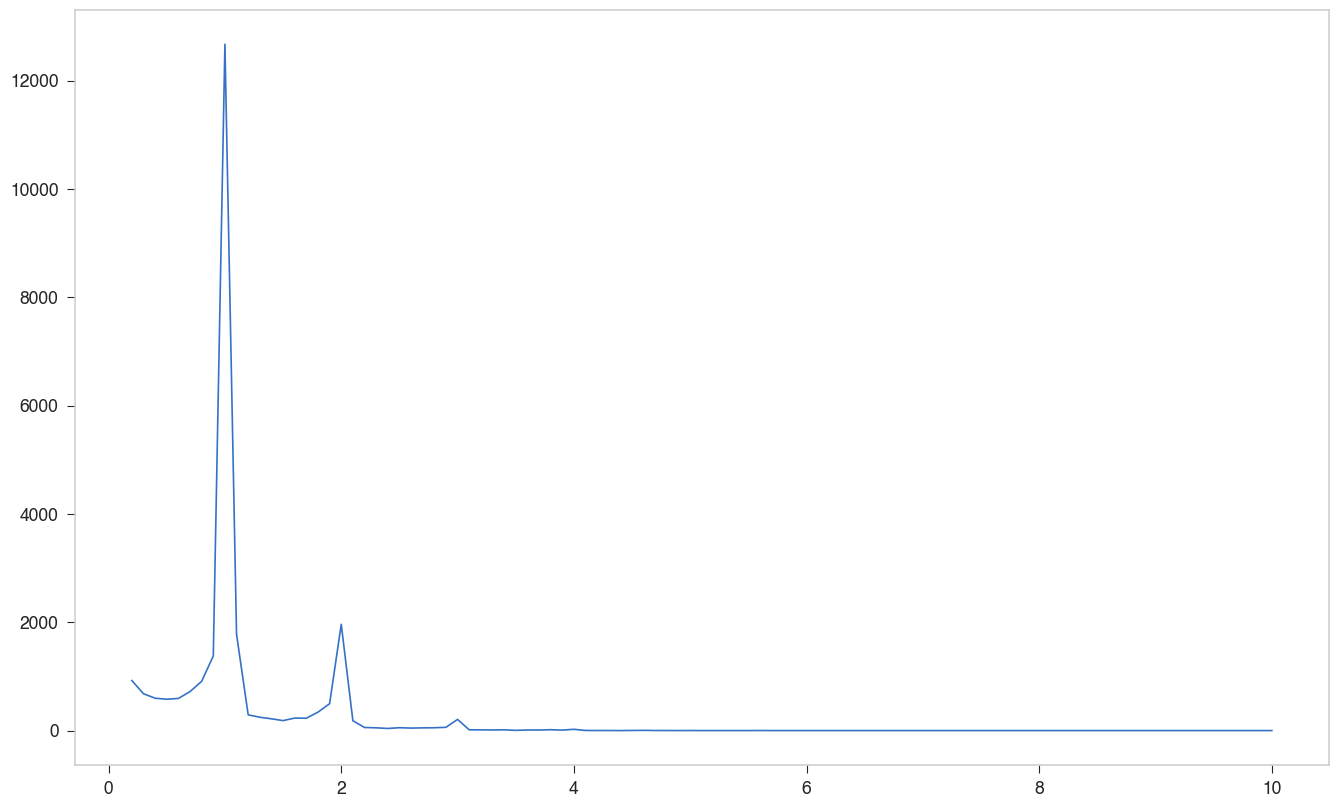

In [65]:
ALA_all_freq = all_freq
ALA_cb_bins = bins
# plt.plot(ALA_cb_bins[1:], ALA_all_freq)
plt.plot(ALA_cb_bins[2:], ALA_all_freq[1:])
# plt.xlim(0,5)

In [47]:
info = []
parser = PDBParser()
all_freq = np.zeros(100)
for i, a in enumerate(a_list):
    pdb = a.split("/")[-1].split(".")[0]
    structure = parser.get_structure("x", a)
    res_list = get_res_list(structure)
    neighbor_list = get_neighbor_list(structure)
    # sequence = get_sequence_from_structure(structure)
    cb_density = calculate_cb_density(res_list, neighbor_list, min_seq_sep=5)
#     info.append([pdb, cb_density])
    cb_density = np.clip(cb_density, 0, 10)
    freq, bins = np.histogram(cb_density, bins=100, range=(0,10))
    all_freq += freq
#     if i == 100:
#         break

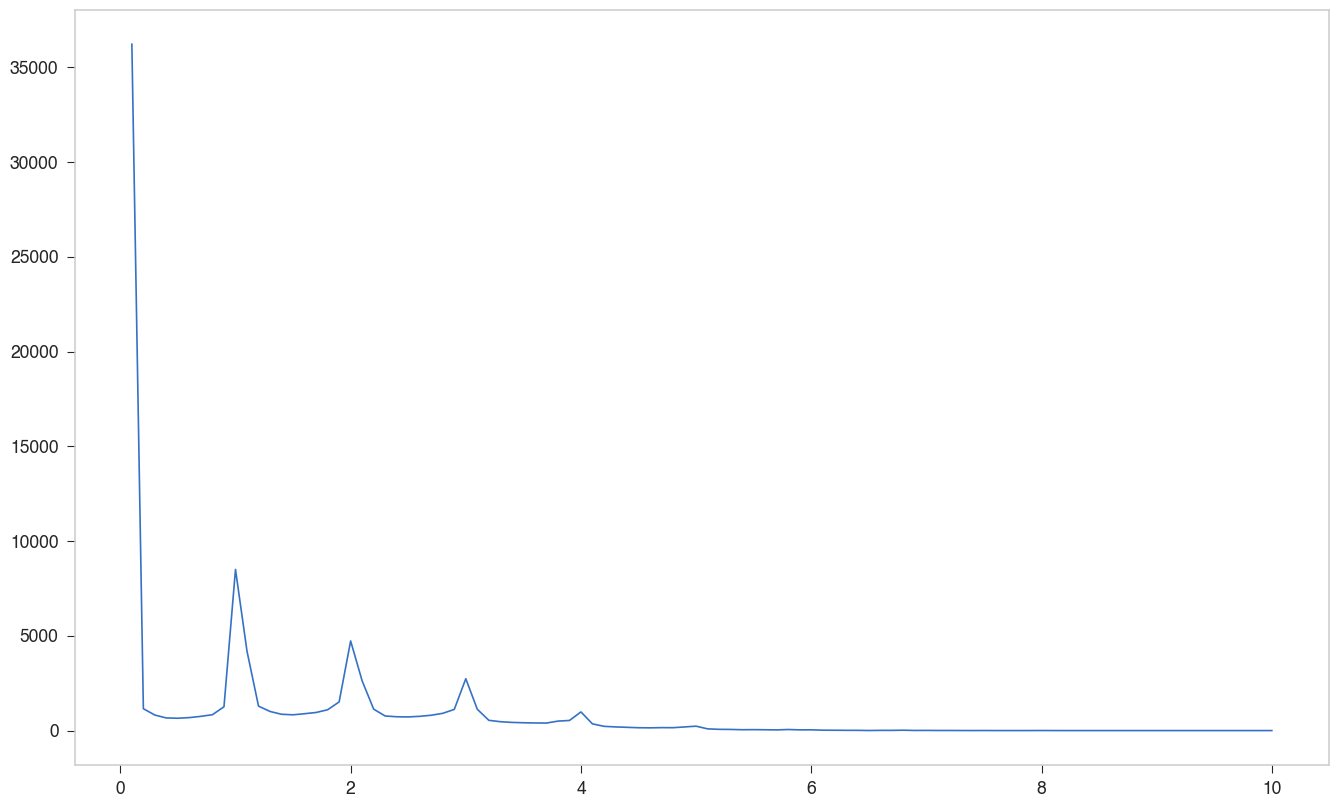

In [48]:
cb_all_freq_5 = all_freq
cb_bins_5 = bins
plt.plot(cb_bins_5[1:], cb_all_freq_5)
# plt.xlim(0,5)

In [49]:
cb_all_freq_5

array([3.6221e+04, 1.1530e+03, 8.1800e+02, 6.6500e+02, 6.5000e+02,
       6.8500e+02, 7.5100e+02, 8.3800e+02, 1.2560e+03, 8.5030e+03,
       4.1870e+03, 1.2890e+03, 1.0080e+03, 8.6000e+02, 8.3200e+02,
       8.9000e+02, 9.5400e+02, 1.0980e+03, 1.5120e+03, 4.7290e+03,
       2.6200e+03, 1.1310e+03, 7.6900e+02, 7.2900e+02, 7.2000e+02,
       7.5200e+02, 8.0900e+02, 9.1000e+02, 1.1170e+03, 2.7360e+03,
       1.1250e+03, 5.4100e+02, 4.6800e+02, 4.3100e+02, 4.1200e+02,
       4.0200e+02, 3.9600e+02, 4.9900e+02, 5.3300e+02, 9.8300e+02,
       3.5400e+02, 2.2400e+02, 1.9300e+02, 1.7100e+02, 1.5000e+02,
       1.4400e+02, 1.5500e+02, 1.5200e+02, 1.9200e+02, 2.3200e+02,
       9.0000e+01, 6.5000e+01, 6.0000e+01, 4.5000e+01, 4.9000e+01,
       4.3000e+01, 3.5000e+01, 5.6000e+01, 3.7000e+01, 4.0000e+01,
       2.0000e+01, 1.7000e+01, 1.3000e+01, 1.2000e+01, 3.0000e+00,
       1.1000e+01, 1.0000e+01, 1.9000e+01, 6.0000e+00, 9.0000e+00,
       5.0000e+00, 5.0000e+00, 3.0000e+00, 1.0000e+00, 3.0000e

In [21]:
data = pd.DataFrame(info, columns=["Protein", "CB_density"])

In [27]:
pdb

'1lnwA01'

In [44]:
structure = parser.get_structure("x", a)
res_list = get_res_list(structure)
neighbor_list = get_neighbor_list(structure)
# sequence = get_sequence_from_structure(structure)
cb_density = calculate_cb_density(res_list, neighbor_list, min_seq_sep=5)

In [45]:
cb_density[cb_density>5]

array([5.2590364])

In [46]:
keep_res = []
for res, larger_than_5 in zip(res_list, cb_density>5):
    if larger_than_5:
        keep_res.append(res)
keep_res

[<Residue LEU het=  resseq=95 icode= >]

In [38]:
keep_res = []
for res, larger_than_5 in zip(res_list, cb_density>6):
    if larger_than_5:
        keep_res.append(res)

In [40]:
keep_res

[<Residue HIS het=  resseq=105 icode= >]

In [37]:
cb_density[cb_density>5]

array([5.86371332, 5.78131243, 5.3421337 , 5.46939593, 5.50159703,
       5.85206336, 5.33396182, 5.25964448, 5.19438714, 5.00654652,
       5.83599955, 5.72115076, 6.46516883, 5.83249954, 5.58289744,
       5.8684185 ])

In [31]:
len(cb_density)

130

In [34]:
cb_density > 5

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False,  True, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False,  True,  True, False, False,  True,
       False, False,  True,  True, False, False,  True, False, False,
        True, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [24]:
np.histogram(cb_density, bins=100, range=(0,10))

(array([3, 0, 1, 1, 0, 0, 0, 1, 0, 3, 0, 1, 1, 3, 0, 4, 2, 1, 3, 7, 7, 1,
        1, 2, 6, 4, 3, 4, 4, 3, 6, 1, 0, 2, 5, 2, 2, 4, 7, 3, 2, 1, 1, 1,
        1, 2, 2, 1, 5, 0, 1, 1, 1, 2, 1, 2, 0, 2, 5, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
         1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
         2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
         3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
         4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
         5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
         6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
         7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
         8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7

In [10]:
cb_all_freq = all_freq
cb_bins = bins

In [14]:
cb_all_freq

array([3.714e+03, 3.850e+02, 2.950e+02, 2.790e+02, 2.470e+02, 2.630e+02,
       2.780e+02, 3.410e+02, 4.820e+02, 2.678e+03, 2.968e+03, 1.077e+03,
       9.220e+02, 8.310e+02, 8.290e+02, 8.840e+02, 9.970e+02, 1.126e+03,
       1.691e+03, 4.594e+03, 3.119e+03, 1.551e+03, 1.375e+03, 1.185e+03,
       1.281e+03, 1.350e+03, 1.457e+03, 1.813e+03, 2.225e+03, 4.084e+03,
       2.552e+03, 1.784e+03, 1.525e+03, 1.513e+03, 1.414e+03, 1.472e+03,
       1.637e+03, 1.821e+03, 2.237e+03, 3.085e+03, 1.630e+03, 1.152e+03,
       1.146e+03, 1.053e+03, 1.032e+03, 1.103e+03, 1.164e+03, 1.221e+03,
       1.429e+03, 1.674e+03, 1.046e+03, 8.040e+02, 7.370e+02, 7.450e+02,
       7.620e+02, 7.200e+02, 7.110e+02, 7.930e+02, 8.430e+02, 9.400e+02,
       5.640e+02, 4.370e+02, 4.090e+02, 3.810e+02, 3.700e+02, 3.620e+02,
       3.570e+02, 3.980e+02, 3.910e+02, 3.410e+02, 1.790e+02, 1.710e+02,
       1.440e+02, 1.100e+02, 1.270e+02, 1.130e+02, 9.600e+01, 1.210e+02,
       9.600e+01, 9.700e+01, 4.500e+01, 3.400e+01, 

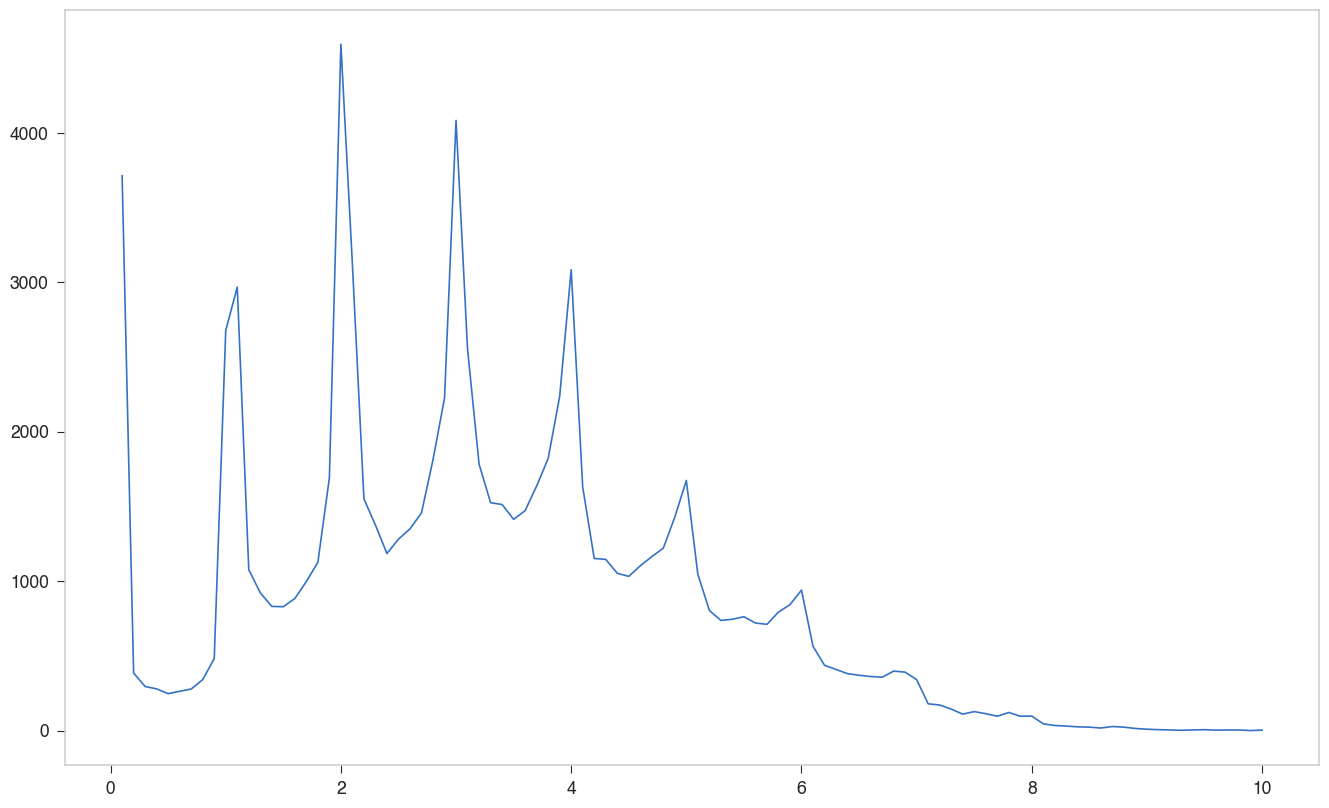

In [12]:
plt.plot(cb_bins[1:], cb_all_freq)
# plt.xlim(0,5)

(0, 5)

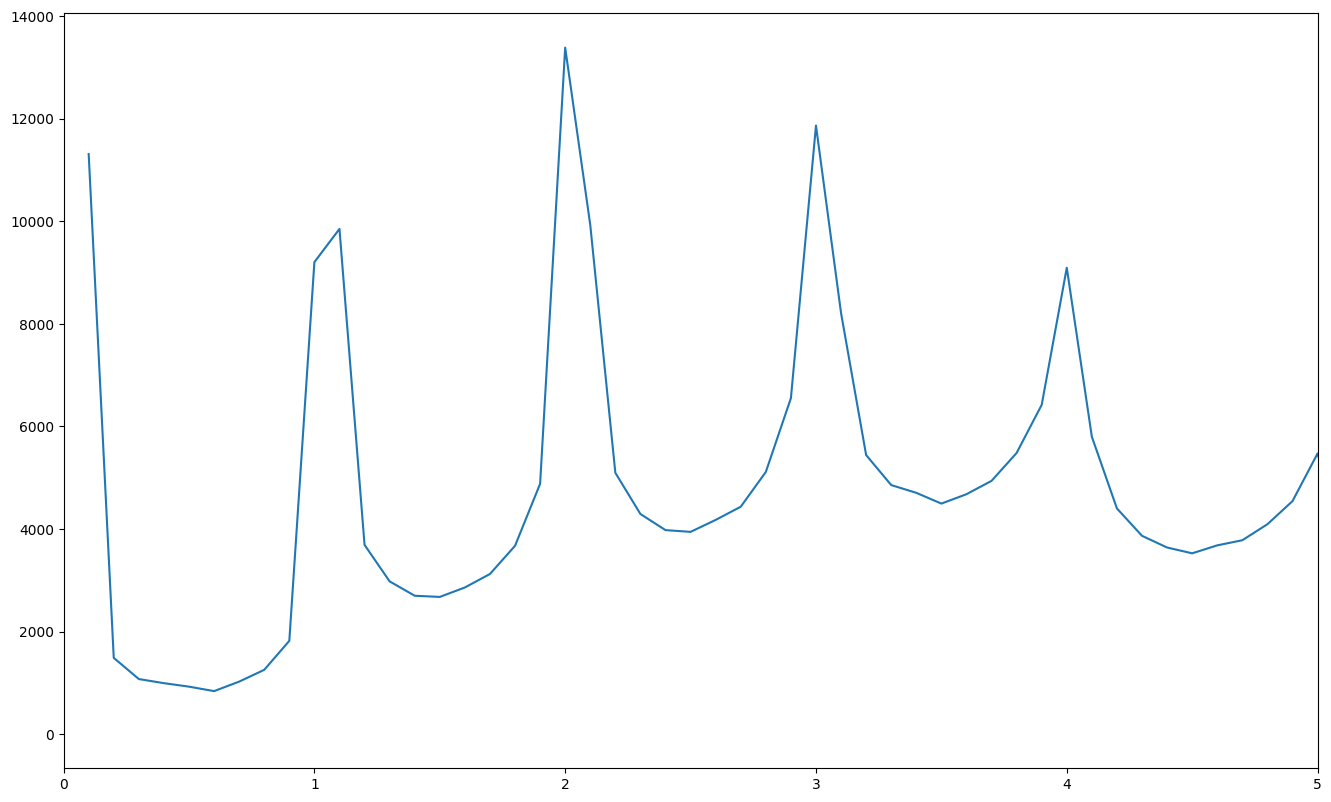

In [80]:
plt.plot(cb_bins[1:], cb_all_freq)
plt.xlim(0,5)

In [73]:
parser = PDBParser()
largest = 20
all_freq = np.zeros(largest*10)
for i, a in enumerate(a_list):
    structure = parser.get_structure("x", a)
    res_list = get_res_list(structure)
    neighbor_list = get_neighbor_list(structure)
    # sequence = get_sequence_from_structure(structure)
    cb_density = calculate_cb_weight_density(res_list, neighbor_list)
    cb_density = np.clip(cb_density, 0, largest)
    freq, bins = np.histogram(cb_density, bins=largest*10, range=(0,largest))
    all_freq += freq
#     if i == 10:
#         break

In [74]:
weight_all_freq = all_freq
weight_bins = bins

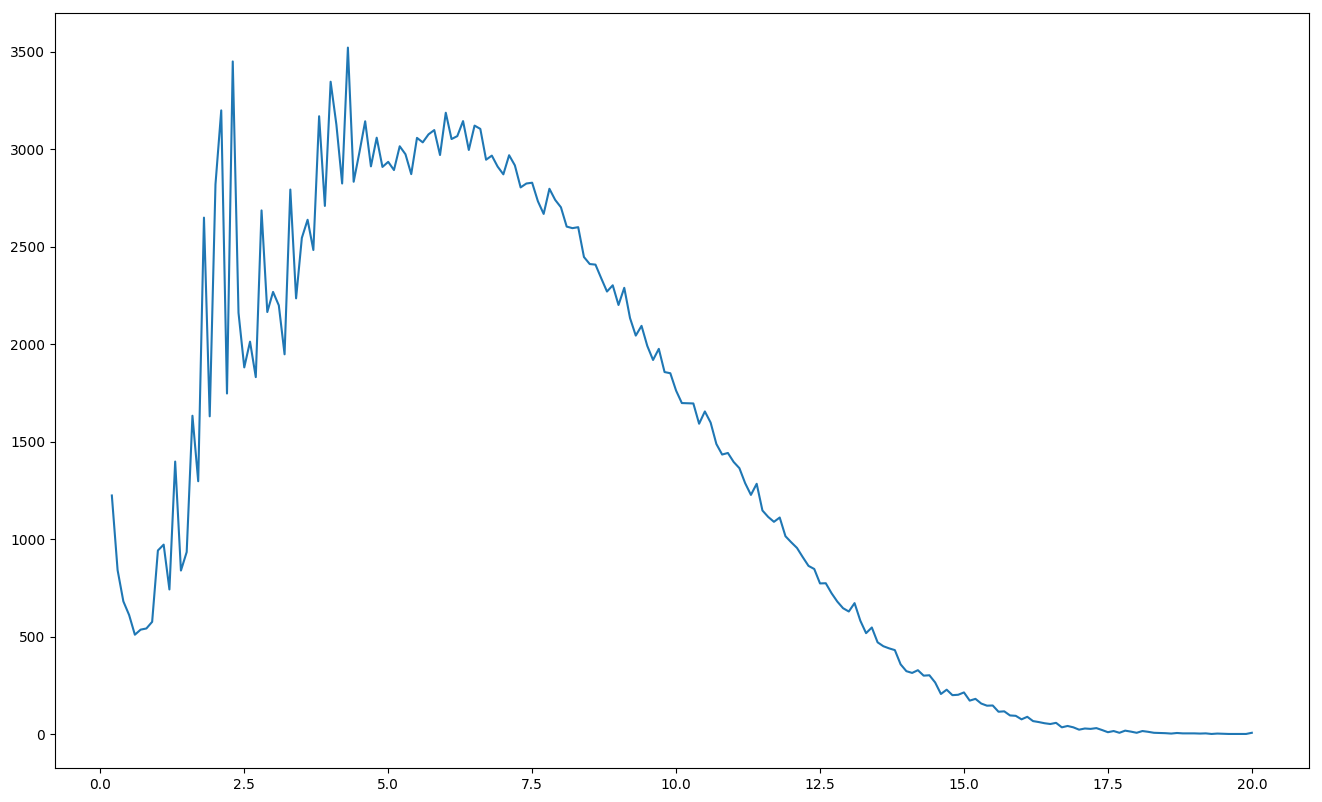

In [81]:
plt.plot(weight_bins[2:], weight_all_freq[1:])


(2, 4)

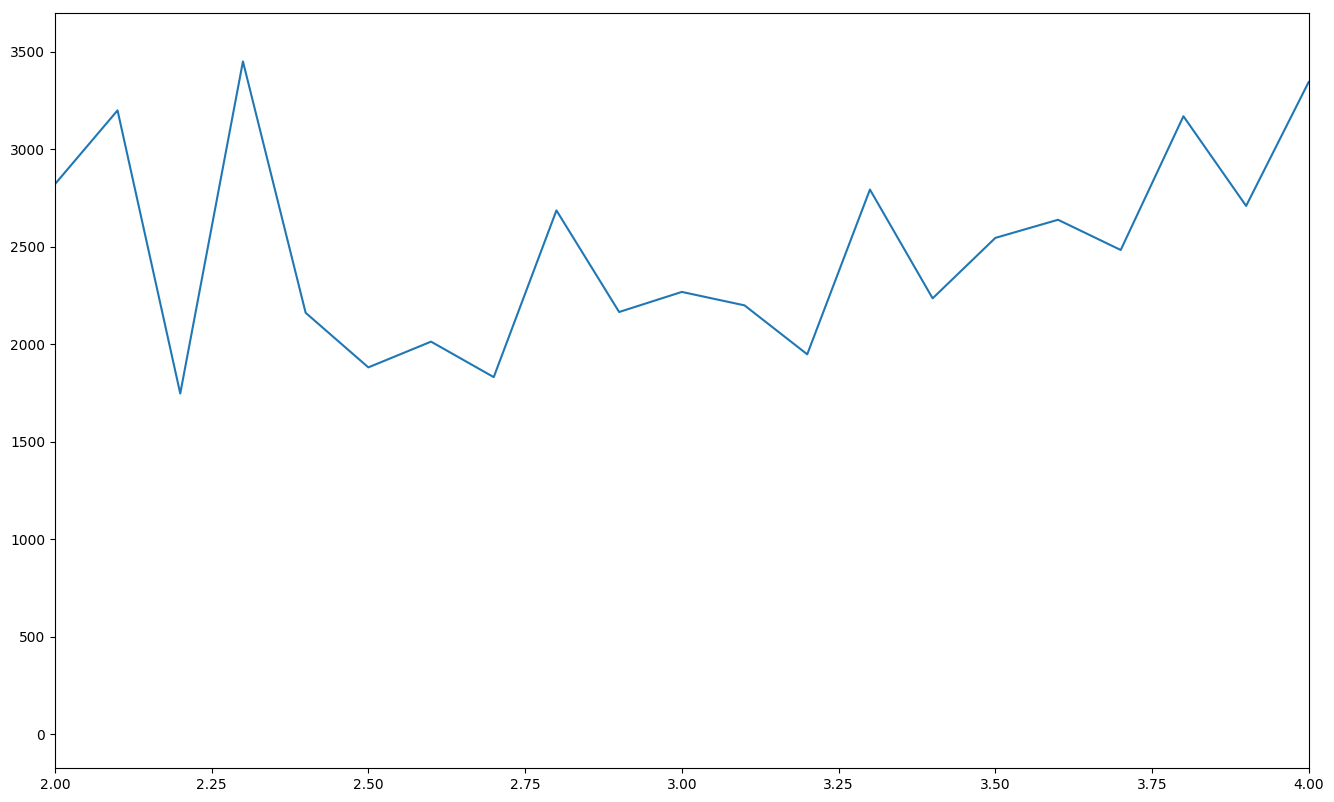

In [83]:
plt.plot(weight_bins[2:], weight_all_freq[1:])
plt.xlim(2,4)

In [10]:
parser = PDBParser()
largest = 600
all_freq = np.zeros(200)
for i, a in enumerate(a_list):
    structure = parser.get_structure("x", a)
    res_list = get_res_list(structure)
    neighbor_list = get_neighbor_list(structure)
    # sequence = get_sequence_from_structure(structure)
    cb_density = calculate_cb_weight_density_2(res_list, neighbor_list)
    cb_density = np.clip(cb_density, 0, largest)
    freq, bins = np.histogram(cb_density, bins=200, range=(0,largest))
    all_freq += freq
    if i == 100:
        break

In [11]:
weight_2_all_freq = all_freq
weight_2_bins = bins

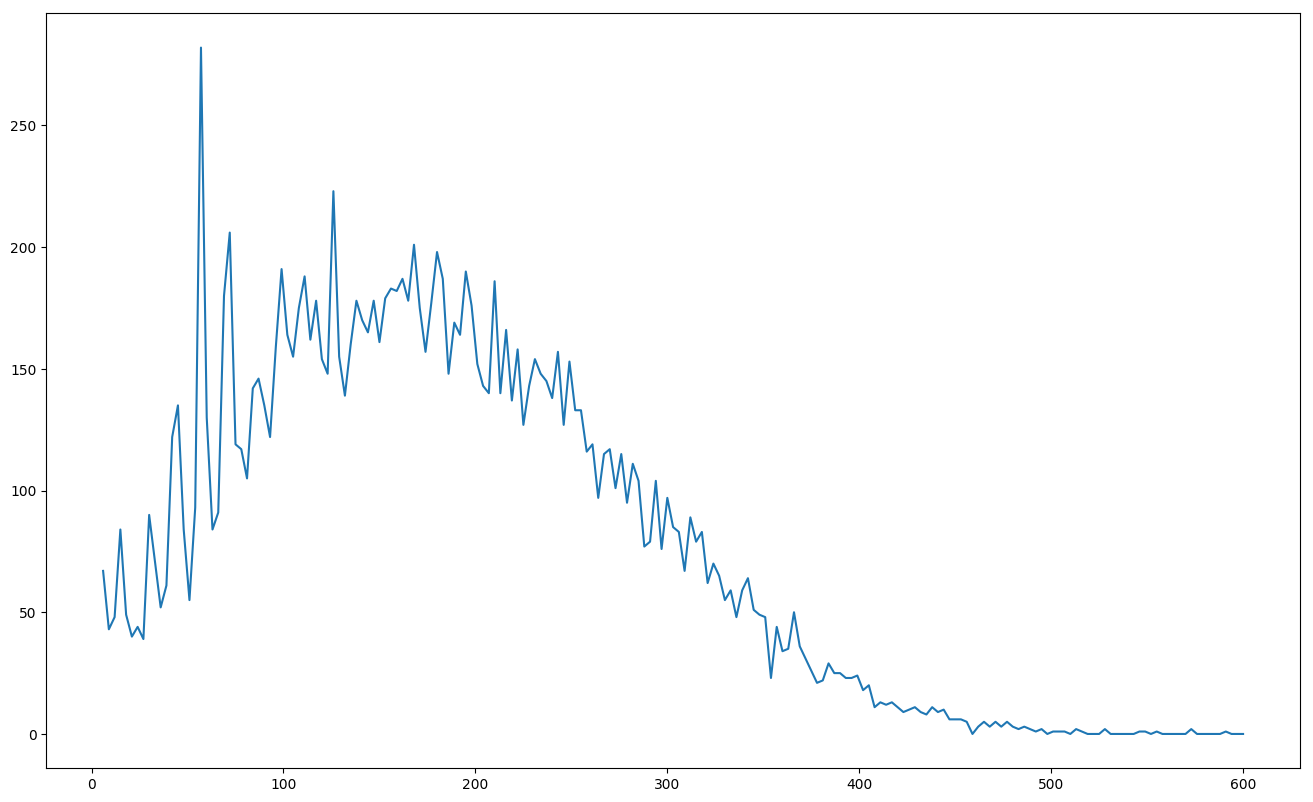

In [12]:
plt.plot(weight_2_bins[2:], weight_2_all_freq[1:])


In [5]:
def calculate_cb_weight_density_2(res_list, neighbor_list, min_seq_sep=2):
    weight_info = pd.read_csv("~/opt/parameters/amino_acid_side_chain_weight", comment="#", sep="\s+")
    weight_info["normalized_weight"] = weight_info["weight"] /(weight_info["weight"].min())
    weight_info["sideChainWeight"] = weight_info["weight"] - 56
    weight_info["normalized_weight_2"] =  (weight_info["sideChainWeight"]  /(weight_info["sideChainWeight"].min()))

    num_residues = len(res_list)
    density = np.zeros(num_residues)
    for res1globalindex, res1 in enumerate(res_list):
        res1index = get_local_index(res1)
        res1chain = get_chain(res1)
        for res2 in get_neighbors_within_radius(neighbor_list, res1, 9.0):
            res2index = get_local_index(res2)
            res2chain = get_chain(res2)
            res2globalindex = get_global_index(res_list, res2)
            if abs(res2index - res1index) >= min_seq_sep or (res1chain != res2chain):
                rij = get_interaction_distance(res1, res2)
                res2type = three_to_one(res2.get_resname())
                try:
                    # weight = float(weight_info.query(f"oneLetterCode == '{res2type}'")["normalized_weight"])
                    weight = float(weight_info.query(f"oneLetterCode == '{res2type}'")["normalized_weight_2"])
                except:
                    print(res2)
                    print(res2type)
                    print(weight_info.query(f"oneLetterCode == '{res2type}'")["normalized_weight"])
                density[res1globalindex] += weight*interaction_well(rij, 4.5, 6.5, 5)
    return density

In [100]:
parser = PDBParser()
all_freq = np.zeros(100)
largest = 20
all_ = []
for i, a in enumerate(a_list):
    structure = parser.get_structure("x", a)
    res_list = get_res_list(structure)
    neighbor_list = get_neighbor_list(structure)
    # sequence = get_sequence_from_structure(structure)
    cb_density = calculate_cb_density(res_list, neighbor_list)
    cb_density = np.clip(cb_density, 0, 10)
    cb_density_weight = calculate_cb_weight_density(res_list, neighbor_list)
    cb_density_weight_2 = calculate_cb_weight_density_2(res_list, neighbor_list)
    cb_density_weight_2 = np.clip(cb_density_weight, 0, 500)
    tmp =pd.DataFrame([cb_density, cb_density_weight, cb_density_weight_2]).T
    all_.append(tmp)
    freq, bins = np.histogram(cb_density, bins=100, range=(0,10))
    all_freq += freq
#     break
    if i == 10:
        break
data = pd.concat(all_)

In [102]:
data.columns = ["density", "weight_density", "weight_density_2"]

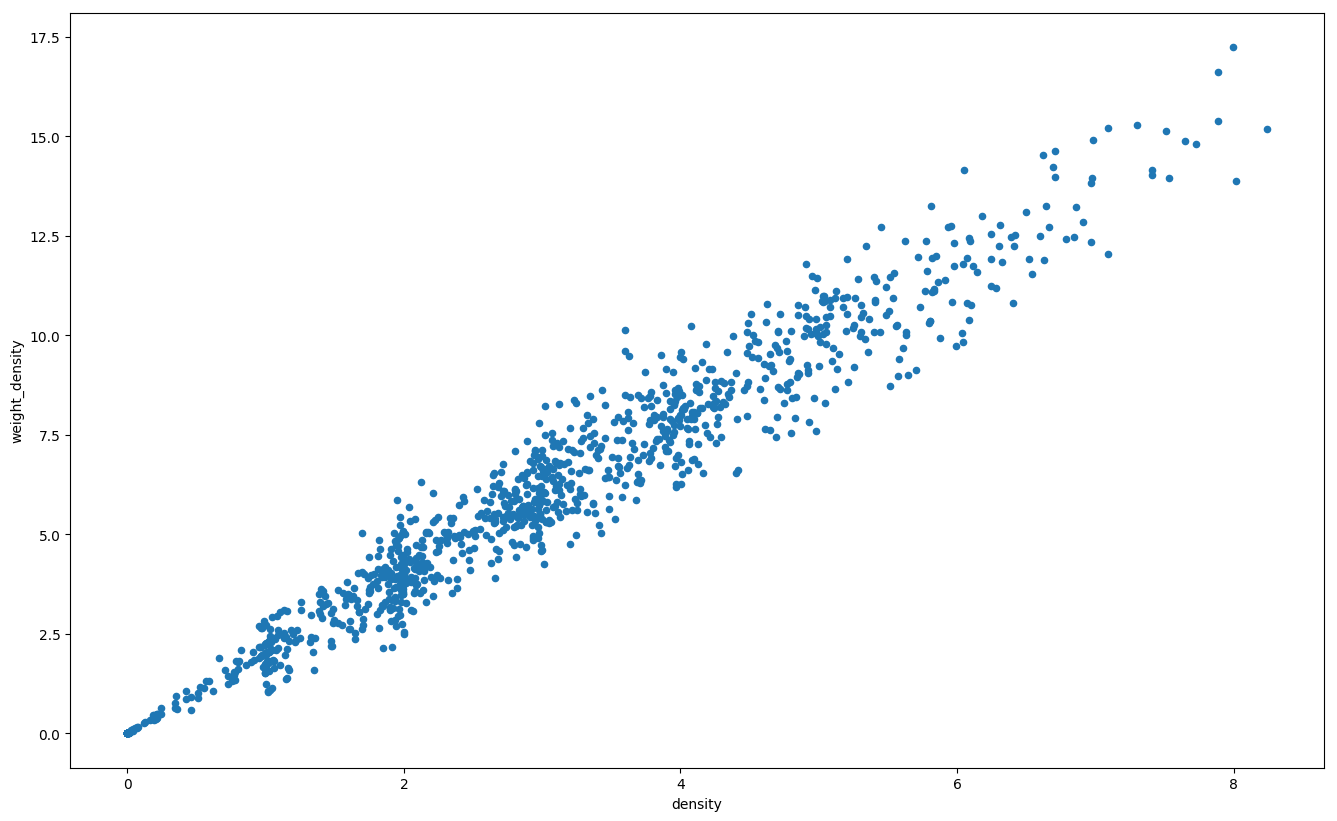

In [103]:
data.plot.scatter("density", "weight_density")

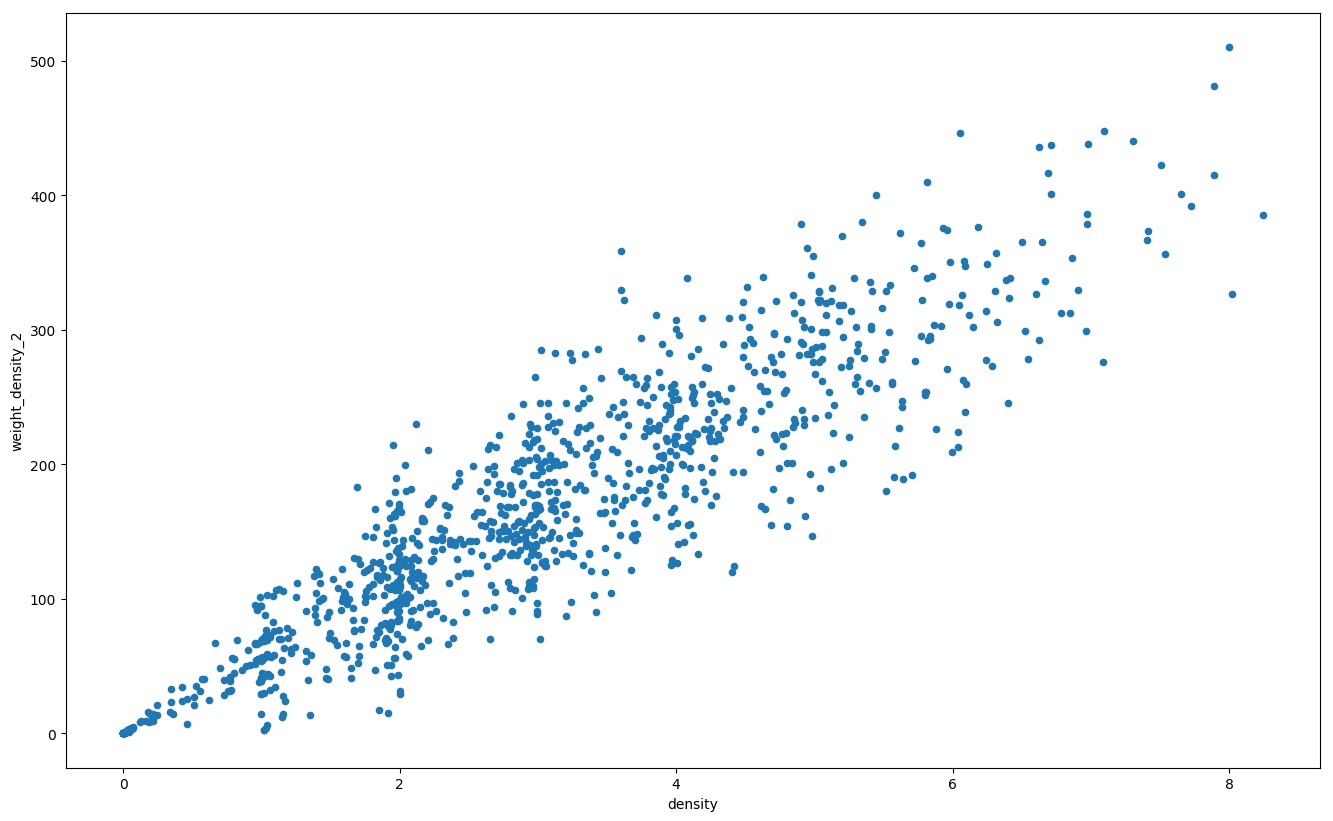

In [104]:
data.plot.scatter("density", "weight_density_2")

(array([66.,  8., 10.,  4.,  6.,  8., 10.,  9., 18.,  8., 26., 22., 10.,
        32., 12., 13., 14., 17., 20., 25., 20., 24., 22., 18., 23., 26.,
        19., 19., 33., 20., 25., 17., 21., 22., 17., 21., 19., 13., 21.,
        22., 12., 18., 21., 19., 25., 15., 14., 12., 17., 15., 15., 10.,
         7.,  7., 15., 14.,  9., 10., 11.,  8.,  8.,  8.,  9.,  9.,  9.,
         4.,  8.,  1.,  4.,  3.,  3.,  4.,  2.,  4.,  3.,  2.,  1.,  0.,
         3.,  0.,  1.,  2.,  1.,  0.,  0.,  3.,  1.,  2.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([3.74212048e-09, 5.10384723e+00, 1.02076945e+01, 1.53115417e+01,
        2.04153889e+01, 2.55192361e+01, 3.06230834e+01, 3.57269306e+01,
        4.08307778e+01, 4.59346250e+01, 5.10384723e+01, 5.61423195e+01,
        6.12461667e+01, 6.63500139e+01, 7.14538612e+01, 7.65577084e+01,
        8.16615556e+01, 8.67654028e+01, 9.18692501e+01, 9.69730973e+01,
        1.02076945e+02, 1.07180792e+02, 1.12284639e+02, 1.17388486e+02,
  

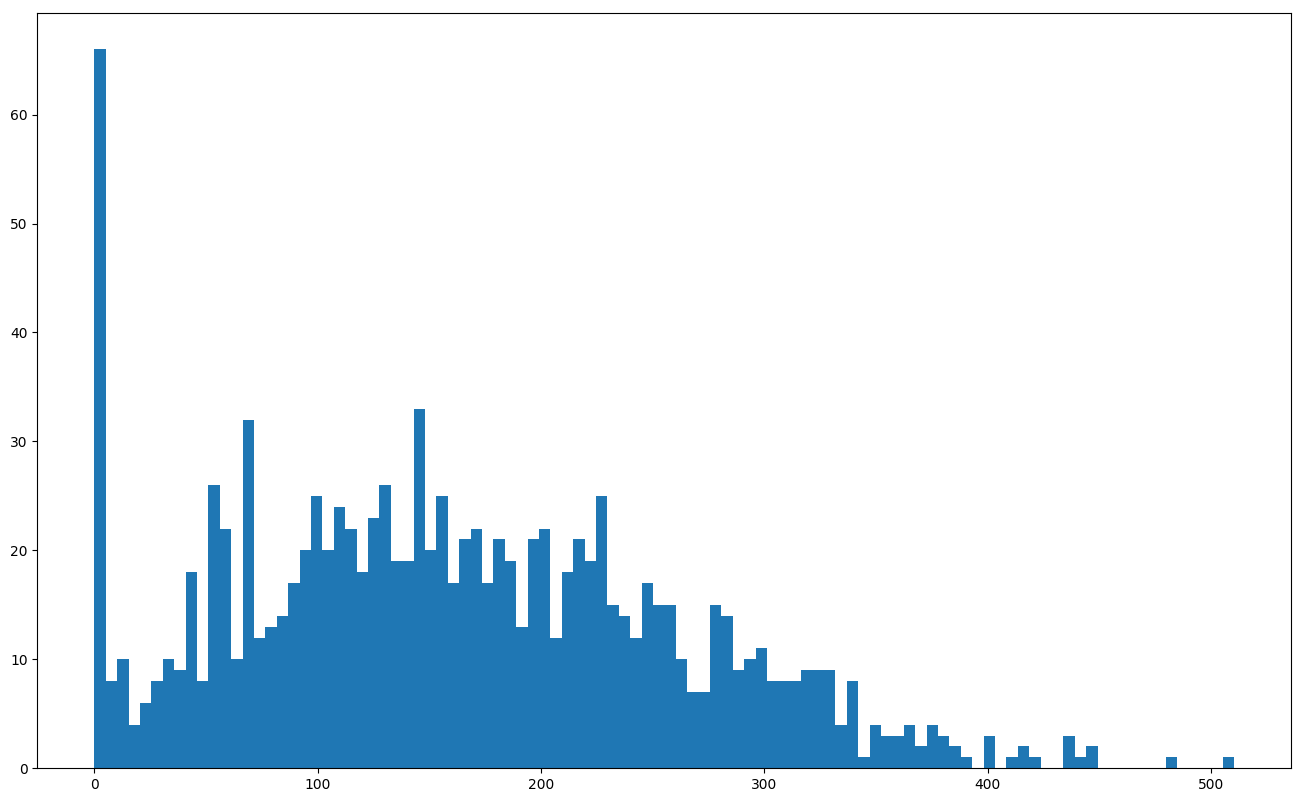

In [106]:
plt.hist(data["weight_density_2"],bins=100)

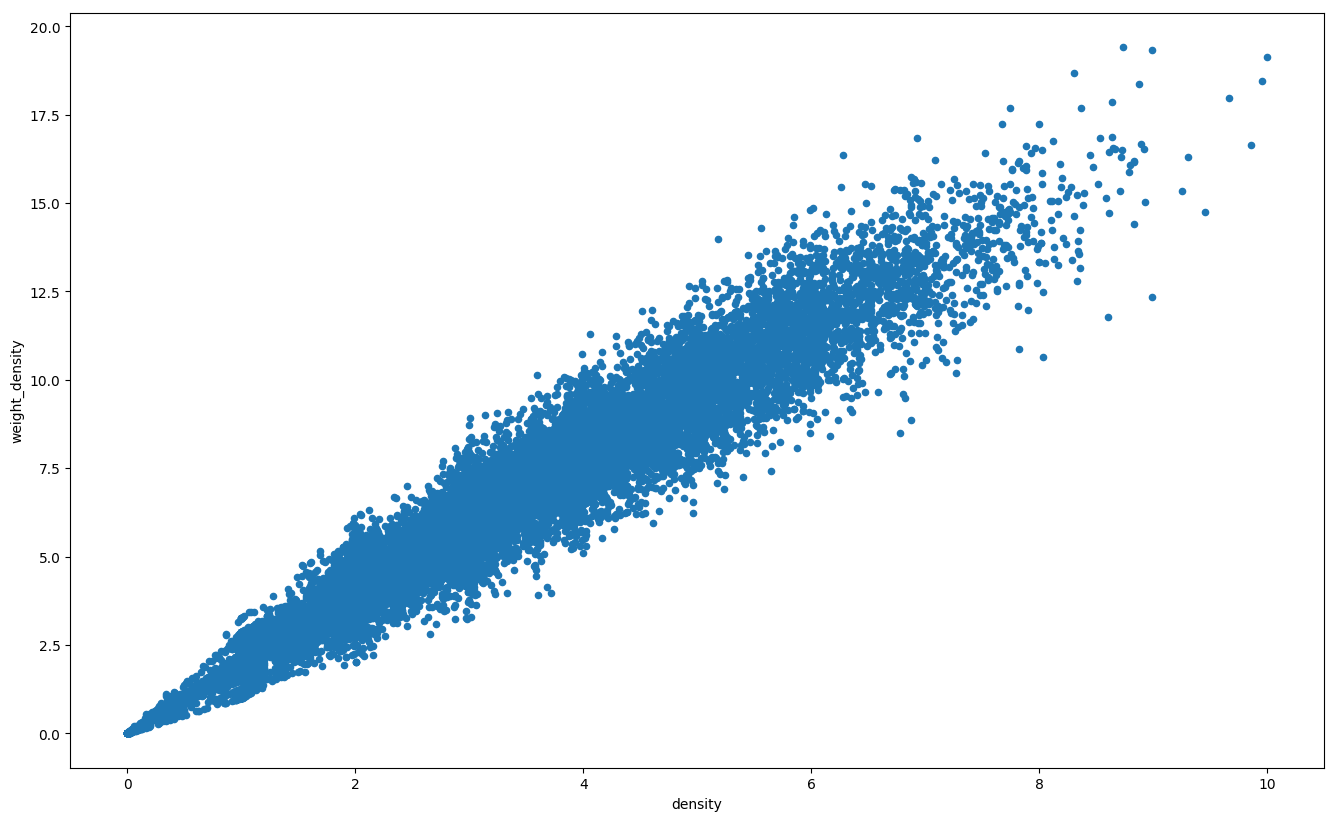

In [98]:
data.plot.scatter("density", "weight_density")

In [22]:
k_bin = 0.1
dz = np.linspace(-50,50)
y = 0.5*(1+np.tanh(k_bin*(dz-15)))

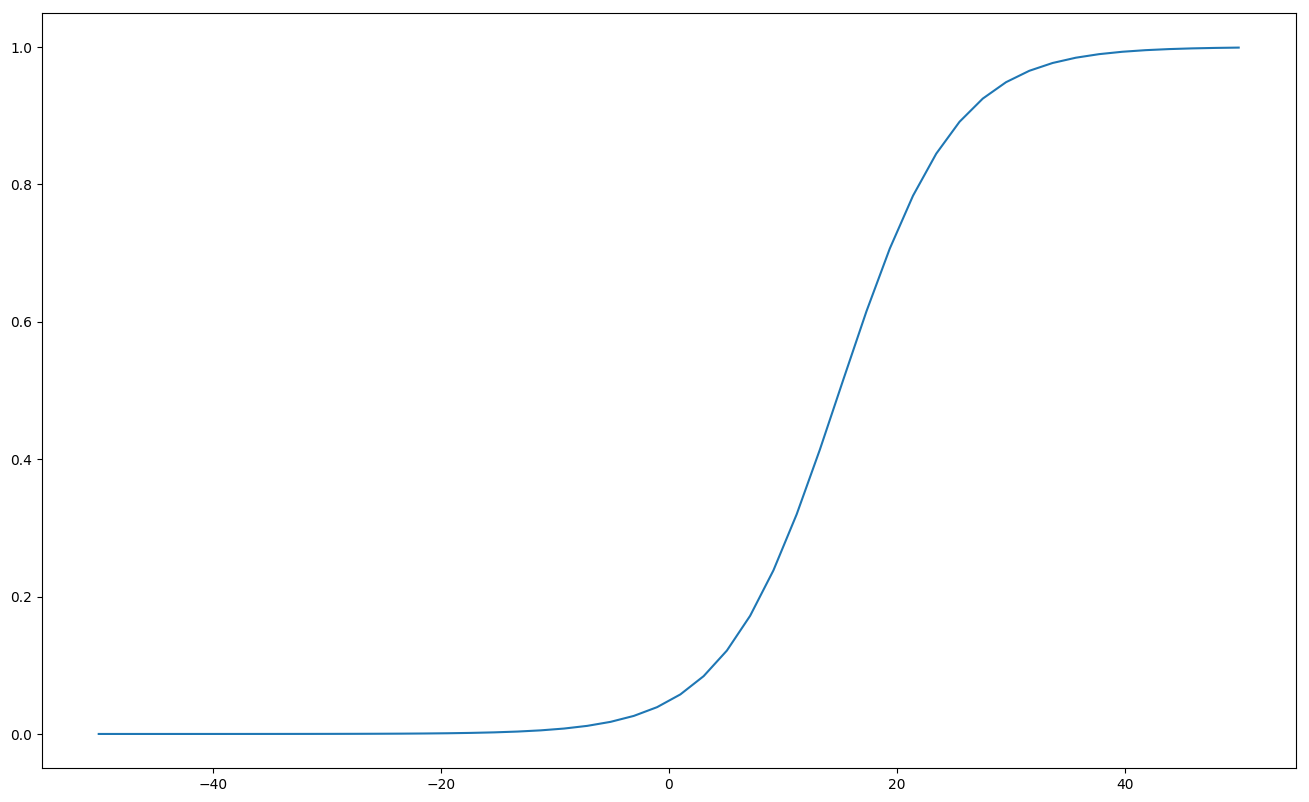

In [23]:
plt.plot(dz, y)

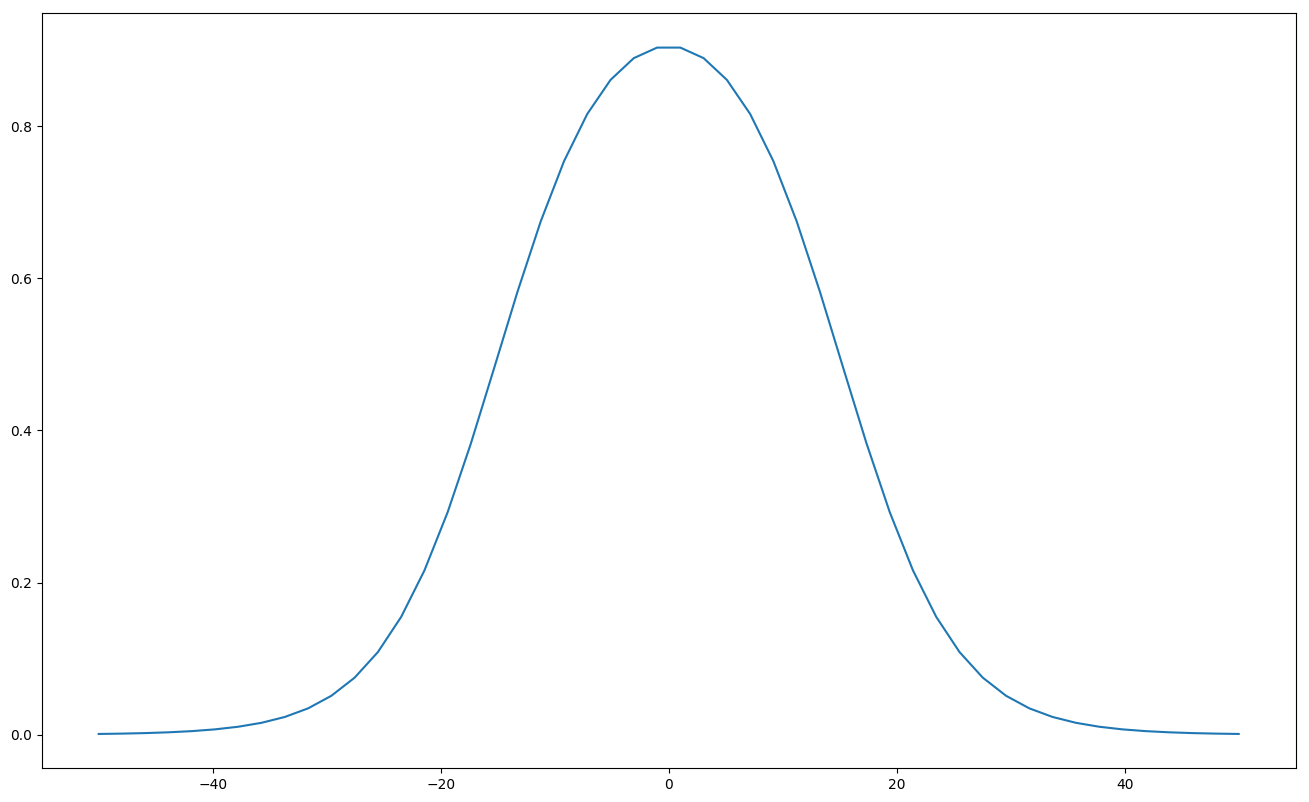

In [24]:
memb_b = 15
y = 0.5*((np.tanh(k_bin*(dz+memb_b)))+(np.tanh(k_bin*(memb_b-dz))))
plt.plot(dz, y)

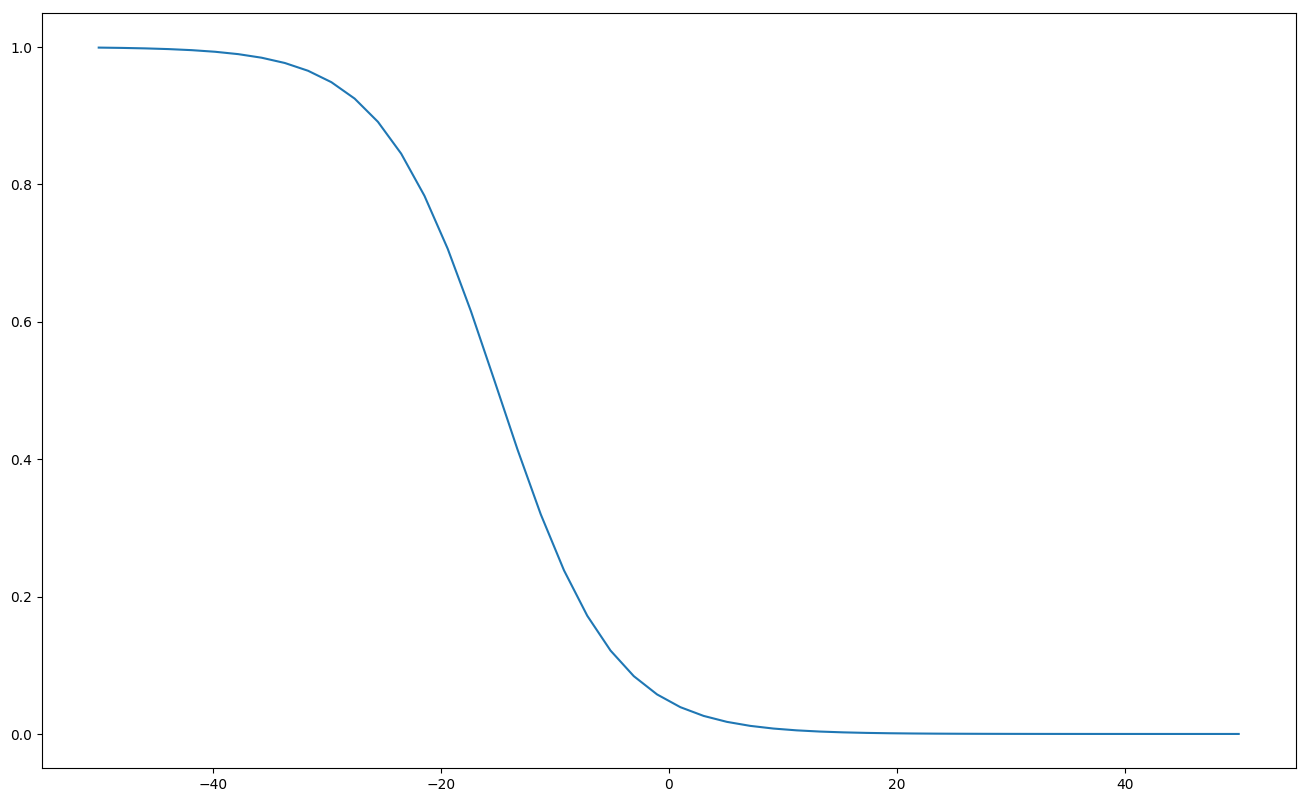

In [25]:
y = 0.5*(1+np.tanh(k_bin*(-memb_b-dz)))
plt.plot(dz, y)

In [88]:
tmp =pd.DataFrame([cb_density, cb_density_weight]).T

In [89]:
pd.concat([tmp,tmp])

,0,1
0,2.993022,4.727698
1,1.806508,3.814755
2,2.309954,4.959676
3,3.308095,6.645009
4,2.786939,5.509010
5,0.556119,1.127559
6,4.274126,8.589912
7,3.618283,7.625045
8,2.179394,5.045787
9,2.978000,5.743504


In [ ]:
values = numpy.arange(10, dtype=int)
bins = numpy.arange(-1, 11)
freq, bins = numpy.histogram(values, bins)

In [38]:
freq, bins = np.histogram([-1,1,11], bins=100, range=(0,10))

In [33]:
freq.shape

(100,)

In [41]:
all_freq

array([669.,  78.,  56.,  49.,  52.,  50.,  48.,  68., 101., 503., 523.,
       200., 125., 147., 140., 168., 168., 187., 263., 697., 567., 248.,
       217., 222., 213., 226., 216., 272., 345., 656., 459., 264., 274.,
       244., 240., 287., 263., 279., 366., 486., 341., 280., 210., 212.,
       196., 207., 209., 235., 266., 298., 240., 200., 170., 155., 119.,
       173., 151., 170., 150., 175., 130.,  92.,  84.,  76.,  82.,  59.,
        73.,  68.,  67.,  71.,  43.,  31.,  29.,  25.,  31.,  27.,  25.,
        22.,  24.,  14.,  11.,  11.,   7.,  12.,   2.,   3.,   7.,   6.,
         5.,   4.,   0.,   0.,   1.,   1.,   1.,   0.,   1.,   0.,   1.,
         2.])

In [37]:
bins

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
        3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
        4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
        5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
        6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
        7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
        8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
        9.9, 10. ])

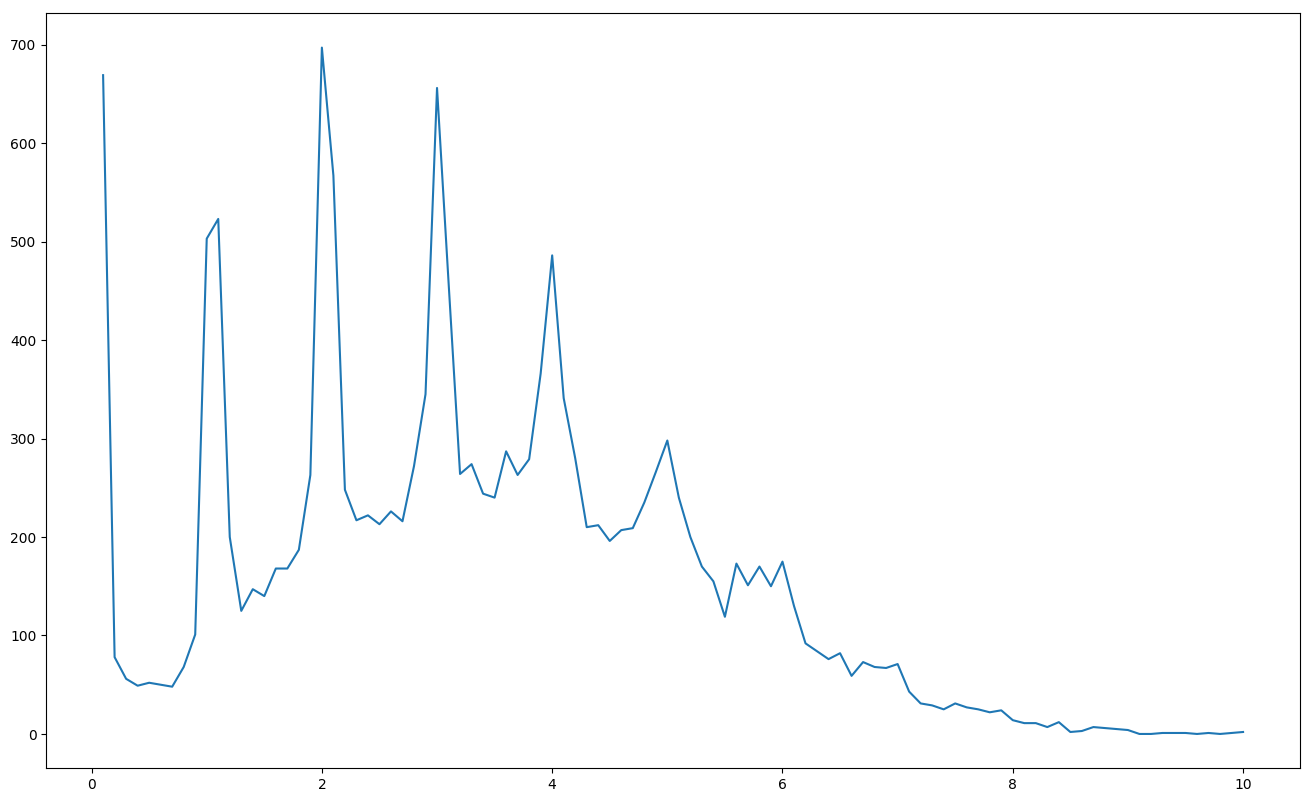

In [45]:
plt.plot(bins[1:], all_freq)


(2, 3)

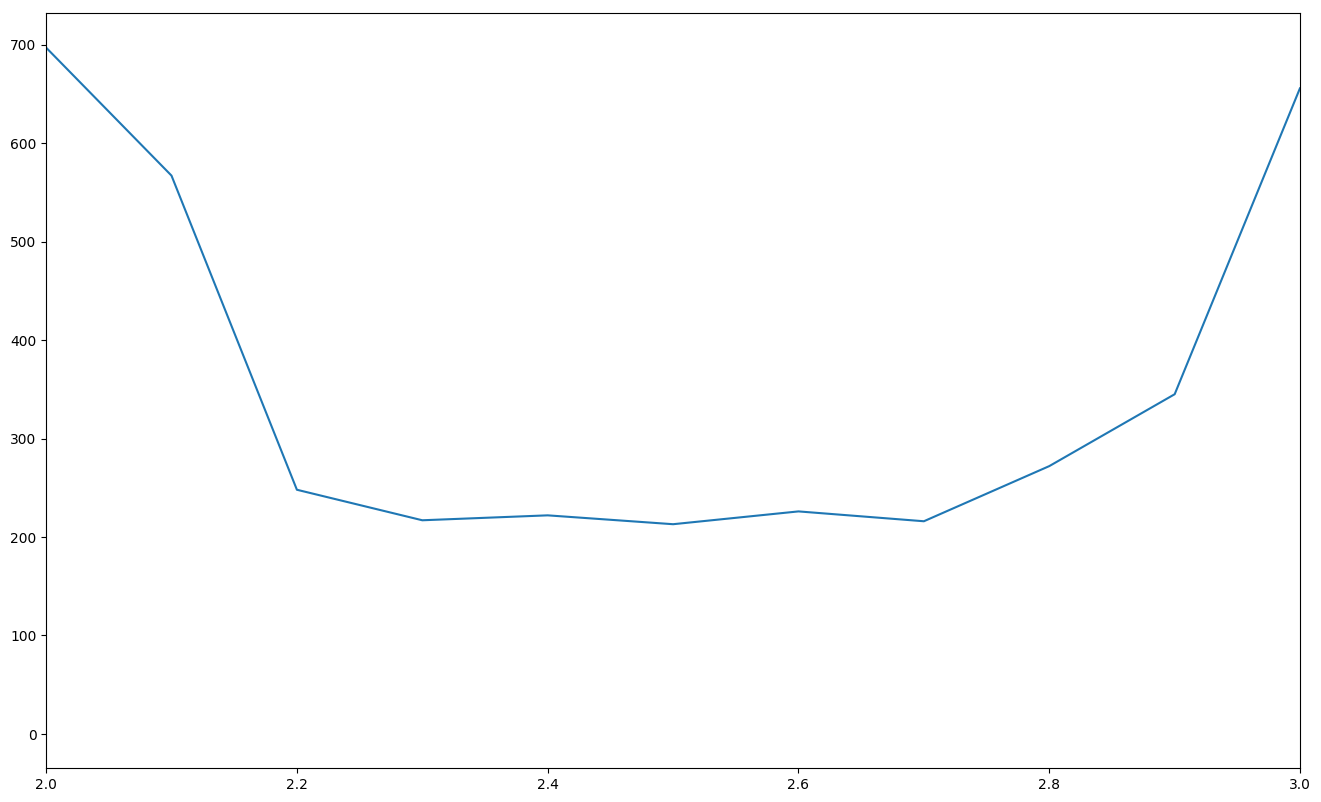

In [46]:
plt.plot(bins[1:], all_freq)
plt.xlim(2,3)

In [36]:
all_freq

array([669.,  78.,  56.,  49.,  52.,  50.,  48.,  68., 101., 503., 523.,
       200., 125., 147., 140., 168., 168., 187., 263., 697., 567., 248.,
       217., 222., 213., 226., 216., 272., 345., 656., 459., 264., 274.,
       244., 240., 287., 263., 279., 366., 486., 341., 280., 210., 212.,
       196., 207., 209., 235., 266., 298., 240., 200., 170., 155., 119.,
       173., 151., 170., 150., 175., 130.,  92.,  84.,  76.,  82.,  59.,
        73.,  68.,  67.,  71.,  43.,  31.,  29.,  25.,  31.,  27.,  25.,
        22.,  24.,  14.,  11.,  11.,   7.,  12.,   2.,   3.,   7.,   6.,
         5.,   4.,   0.,   0.,   1.,   1.,   1.,   0.,   1.,   0.,   1.,
         1.])

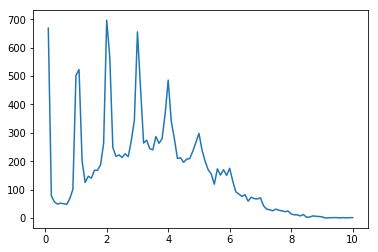

In [35]:
plt.plot(bins[1:], all_freq)

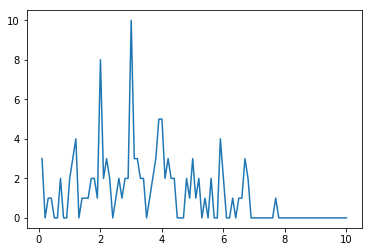

In [29]:
plt.plot(bins[1:], all_freq)

In [19]:
len(cb_density)

119

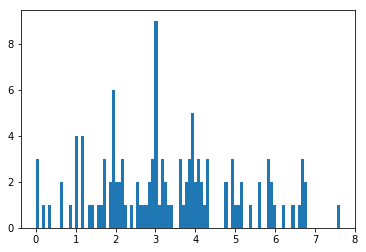

In [12]:
_ = plt.hist(cb_density, bins=100)

In [ ]:
fileName = "/Users/weilu/Research/server/feb_2020/cath_dataset_shuffle_optimization/phi_figures/protein_list_phi_pairwise_contact_well4.5_6.5_5.0_10phi_density_mediated_contact_well6.5_9.5_5.0_10_2.6_7.0_phi_decoy_summary.txt"
a = np.loadtxt(fileName)
np.savetxt("/Users/weilu/Research/server/feb_2020/cath_dataset_shuffle_optimization/phi_figures/log_decoy.txt", np.log(a))

fileName = "/Users/weilu/Research/server/feb_2020/cath_dataset_shuffle_optimization/phi_figures/protein_list_phi_pairwise_contact_well4.5_6.5_5.0_10phi_density_mediated_contact_well6.5_9.5_5.0_10_2.6_7.0_phi_native_summary.txt"
a = np.loadtxt(fileName)
np.savetxt("/Users/weilu/Research/server/feb_2020/cath_dataset_shuffle_optimization/phi_figures/log_native.txt", np.log(a))

In [ ]:

a = "/Users/weilu/Research/server/feb_2020/energy_evaluations_and_database_survey/my_CATH_database/1l0oC00.pdb"
structure = parser.get_structure("x", a)

In [ ]:
%%time
parser = PDBParser()
info = []
skipped_residues_count = 0
# for i, a in enumerate(a_list[:300]):
for i, a in enumerate(a_list):
    pdb = a.split("/")[-1].split(".")[0]
    structure = parser.get_structure("x", a)
    neighbor_list = get_neighbor_list(structure)
    for res1 in structure.get_residues():
        resName1 = res1.get_resname()
        if resName1 == "GLY":
            continue
        set_of_all_non_H_atoms = get_all_non_H_atoms(res1)
        if set_of_all_non_H_atoms != res_set[resName1]:
            skipped_residues_count += 1
            # print("skip", resName, res.get_id(), "atom not complete", set_of_all_non_H_atoms, "should be ", res_set[resName])
            continue
        x_com_1 = get_side_chain_center_of_mass(res1.get_atoms())
        ca_1 = res1["CA"].get_coord()
        cb_1 = res1["CB"].get_coord()
        for res2 in get_neighbors_within_radius(neighbor_list, res1, 10.0):
            resName2 = res2.get_resname()
            if resName2 == "GLY":
                continue
            set_of_all_non_H_atoms = get_all_non_H_atoms(res2)
            if set_of_all_non_H_atoms != res_set[resName2]:
                skipped_residues_count += 1
                # print("skip", resName, res.get_id(), "atom not complete", set_of_all_non_H_atoms, "should be ", res_set[resName])
                continue
            if res1 == res2:
                continue
            x_com_2 = get_side_chain_center_of_mass(res2.get_atoms())
            ca_2 = res2["CA"].get_coord()
            cb_2 = res2["CB"].get_coord()
            info.append([pdb, res1.id[1], resName1, res2.id[1], resName2, dis(ca_1, ca_2), dis(x_com_1, x_com_2), dis(cb_1, cb_2), dis(ca_1, x_com_2), dis(x_com_1, ca_2)])
print("skipped_residues_count", skipped_residues_count)